In this code, I want to compare slope constrained and linear spline model. for the former, i will set the same grid which i will use for the latter. thus both the models would be equivalent and ideally should behave the same!

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from activations.linearspline import LinearSpline

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [2]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader





In [3]:
# Function to generate data from a 1D Laplace distribution
def generate_laplace_data(mean, scale, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Laplace distribution.

    Parameters:
    - mean: Mean (location parameter) of the Laplace distribution
    - scale: Scale (diversity) parameter of the Laplace distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.laplace(loc=mean, scale=scale, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data




In [4]:
# GENERATE GAUSSIAN DATA
# mean = 3.0#2
# std_dev = 3.0
# total_samples = 8000#50000

# train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)

# GENERATE LAPLACE DATA
mean = 4.5
scale = 6
total_samples = 10000
# for each minibatch, new data
#
train_data, val_data, test_data = generate_laplace_data(mean, scale, total_samples)
print(f"Train size: {len(train_data)}, Val size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 7000, Val size: 1500, Test size: 1500


In [5]:
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 20#16#32#16#16#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 7000
Validation set size: 1500
Test set size: 1500


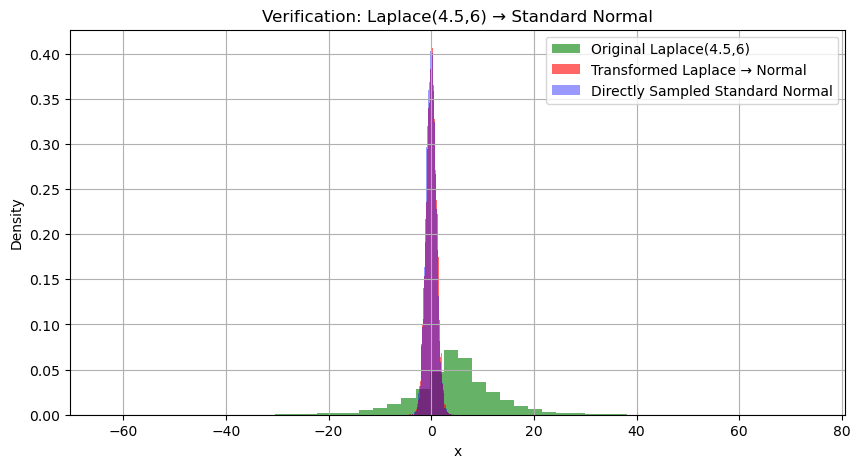

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace

# Transformation function for Laplace(mu, b) → Standard Normal
def laplace_to_normal(x, mu=0, b=1):
    """
    Transforms a Laplace(mu, b) distributed variable into a standard normal.
    
    Args:
    - x: Input Laplace-distributed samples.
    - mu: Mean of the Laplace distribution.
    - b: Scale parameter of the Laplace distribution.
    
    Returns:
    - Transformed values following a standard normal distribution.
    """
    # Compute shifted & scaled Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))
    # Apply inverse CDF of standard normal
    return norm.ppf(F_X)

# Step 1: Sample from a Laplace distribution with custom mean and scale
num_samples = 10000
mu, b = mean, scale  # Example: Laplace(2, 1.5)
laplace_samples = laplace.rvs(loc=mu, scale=b, size=num_samples)

# Step 2: Apply transformation
normal_samples_transformed = laplace_to_normal(laplace_samples, mu, b)

# Step 3: Sample directly from standard normal for comparison
normal_samples_direct = norm.rvs(size=num_samples)

# Step 4: Plot histograms before and after transformation
plt.figure(figsize=(10, 5))

# Original Laplace distribution before transformation
plt.hist(laplace_samples, bins=50, density=True, alpha=0.6, color='g', label=f'Original Laplace({mu},{b})')

# Transformed Laplace samples
plt.hist(normal_samples_transformed, bins=50, density=True, alpha=0.6, color='r', label='Transformed Laplace → Normal')

# Direct Standard Normal samples
plt.hist(normal_samples_direct, bins=50, density=True, alpha=0.4, color='b', label='Directly Sampled Standard Normal')

# Labels and legend
plt.title(f"Verification: Laplace({mu},{b}) → Standard Normal")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


In [7]:
from scipy.stats import norm



def transformation_laplace_to_std_normal(mu=0, b=1, x_range=(-10,10), num_points=41):
    # Define x values
    x = np.linspace(x_range[0], x_range[1], num_points)

    # Compute Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

    # Compute the transformation function T(x)
    T_x = norm.ppf(F_X)

    return x,T_x

def plot_transformation(mu=0, b=1, x_range=(-5, 5), num_points=1000):
    """
    Plots the transformation function T(x) = Φ⁻¹(F_X(x)) that maps a 
    Laplace(mu, b) distributed variable to a standard normal.
    
    Args:
    - mu: Mean of the Laplace distribution.
    - b: Scale parameter of the Laplace distribution.
    - x_range: Tuple defining the range of x values for the plot.
    - num_points: Number of points in the plot.
    
    Returns:
    - A plot of T(x) = Φ⁻¹(F_X(x)).
    """
    x,T_x = transformation_laplace_to_std_normal(mu=mu, b=b, x_range=x_range, num_points=num_points)

    # Plot T(x)
    plt.figure(figsize=(7, 5))
    plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$', color='b')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.xlabel("$x$")
    plt.ylabel("$T(x)$")
    plt.title(f"Transformation Function from Laplace({mu}, {b}) to Standard Normal")
    plt.legend()
    plt.grid(which='both')  # Optional: Add a grid
    plt.minorticks_on()

    # Bold major grid lines
    plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

    # Light minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
    plt.show()


In [8]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian, alpha_nll=1,return_indiv_loss=0):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    # print("det jacobian is:"); print(det_jacobian)
    #loss_2 = torch.sum(torch.log(torch.abs(det_jacobian)))
    loss_2 = torch.sum(torch.log(det_jacobian)) # coy slopes are always positive
    # print("torch.log(torch.abs(det_jacobian):",torch.log(torch.abs(det_jacobian)))
    # print(f"loss 1 is: {loss_1} and loss 2 is: {loss_2}")
    dataset_length = z.size(0)
    loss_with_alpha = (loss_1-loss_2)/ dataset_length # earlier i have some multiplicative alpha here but i removed it as we dont need it
    loss_normal = (loss_1 - loss_2)/ dataset_length
    if return_indiv_loss:
        return loss_with_alpha, loss_normal,loss_1/dataset_length, loss_2/dataset_length
    return loss_with_alpha, loss_normal

In [9]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(5, 5))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.4, 
                density=True, label=labels_list[i])
        plt.legend()

In [10]:
# plot splines with annotations
def plot_with_annotations(x, y,label="with const coeffs",
                title="Plot with (x, y) Annotations", 
            xlabel="X-axis", ylabel="Y-axis",
            txt_color="red", annotate=1, style="-o"):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, style,label=label)  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    if annotate:
        for x_val, y_val in zip(x, y):
            plt.annotate(
                f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
                (x_val, y_val),  # The point to annotate
                textcoords="offset points",  # Offset the text slightly
                xytext=(5, 5),  # Offset (5, 5) pixels
                fontsize=8,  # Font size of the annotation
                color=txt_color # Optional: text color
            )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(which='both')  # Optional: Add a grid
    plt.minorticks_on()

    # Define x values
    x = np.linspace(-40, 40, 1000)

    # Compute Laplace CDF
    F_X = np.where(x < mu, 0.5 * np.exp((x - mu) / b), 1 - 0.5 * np.exp(-(x - mu) / b))

    # Compute the transformation function T(x)
    T_x = norm.ppf(F_X)

    # Plot T(x)
    plt.plot(x, T_x, label=r'$T(x) = \Phi^{-1}(F_X(x))$', color='b')

    # Bold major grid lines
    plt.grid(which='major', linestyle='-', linewidth=1.5, alpha=0.9, color='black')

    # Light minor grid lines
    plt.grid(which='minor', linestyle=':', linewidth=0.7, alpha=0.5, color='gray')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()

In [11]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [12]:
# train and evaluate fn.
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    alpha_nll=1,
    track_coefficients = False, type_model="ls"#"scls"
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    loss_1_list=[]
    loss_2_list=[]
    val_losses = []  # List to store validation losses
    model_params_history = []  # To store model state_dicts for each epoch
    # Save a copy of the model's state_dict
    model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_train_and_regul_loss=0.0
        total_loss_1=0.0; total_loss_2=0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            if type_model=="ls":  #activations.linearspline_slope_constraint.LinearSplineSlopeConstrained
                slope_const_coeffs = model.lipschitz_coefficients_vect.detach().numpy()
            elif type_model== "scls":
                slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]
            # print(f"shape of inputs: {inputs.size()}")
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss, loss_normal, loss_1, loss_2 = nll_loss(encoded, model.grad_x_temp,
                                            alpha_nll=alpha_nll,return_indiv_loss=1)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)
            # print(f"tv2 regul: {tv2_regul}")
            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss
            # print(f"lambda_tv2 {(lambda_tv2 )} x tv2_regul: {lambda_tv2 * tv2_regul}")
            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_and_regul_loss += total_loss.item()
            total_train_loss += train_loss.item()#loss_normal.item()#train_loss.item()
            total_loss_1 +=loss_1.item()
            total_loss_2 += loss_2.item()# initially this + was missing
        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # Save a copy of the model's state_dict
        model_params_history.append({k: v.clone() for k, v in model.state_dict().items()})

        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_train_and_regul_loss = total_train_and_regul_loss / len(train_loader)
        avg_loss_1 = total_loss_1/len(train_loader)
        avg_loss_2 = total_loss_2/len(train_loader)
        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss,_ = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f" train NLL+{lambda_tv2 * int(tv2_regulation)}XTV2: {avg_train_and_regul_loss}, "
                    f"data avg loss-1: {avg_loss_1} ,"
                    f"data avg loss-2: {avg_loss_2} ,"
                    f"Training NLL Loss: {average_train_loss}, "
                    f"Validation NLL Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses,model_params_history, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses,model_params_history


In [13]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
def plot_coefficients_evolution(num_coeffs, coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs = List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    '''
    # Calculate grid dimensions dynamically
    cols = math.ceil(math.sqrt(num_coeffs))  # Number of columns
    rows = math.ceil(num_coeffs / cols)      # Number of rows
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axs = axs.flatten()  # Flatten for easier indexing

    for i in range(num_coeffs):
        ax = axs[i]
        ax.plot(coeffs[:, i], "-o", label=f"coeff[{i}]")
        ax.plot(slope_constr_coeffs[:, i], ":o", label=f"slope constr coeff[{i}]")
        ax.set_title(f"Coefficient {i}")
        ax.set_ylabel("Value")
        if log_scale:
            ax.set_yscale("log")
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Hide unused subplots
    for i in range(num_coeffs, len(axs)):
        axs[i].axis('off')
    
    # Set x-label for bottom row only
    for i in range(len(axs) - cols, len(axs)):
        axs[i].set_xlabel("Training epochs")
    
    fig.suptitle("Evolution of coefficients with training of a spline", y=1.00)
    plt.tight_layout()
    plt.show()

    


In [15]:
# fn to load weights into model. This fn is used later to visualise the code space during training
# to study training dynammics
def load_weights_into_model(model, parameters_dict):
    """
    Loads weights into the SplineNN model using a state_dict-like dictionary.

    Args:
    - model (SplineNN): The model into which weights are to be loaded.
    - parameters_dict (dict): A dictionary of parameters (state_dict format).
      Keys should match those in the model's state_dict.

    Returns:
    None
    """
    # Ensure the keys match between the input dictionary and the model's state_dict
    model_state_dict = model.state_dict()
    
    # Verify all keys are present in the provided parameters
    for key in model_state_dict.keys():
        if key not in parameters_dict:
            raise ValueError(f"Key '{key}' not found in provided parameters.")

    # Load parameters into the model
    for name, param in model_state_dict.items():
        if name in parameters_dict:
            param.data.copy_(parameters_dict[name])
        else:
            raise ValueError(f"Missing parameter for layer: {name}")

    # print("Weights successfully loaded into the model.")

In [16]:
# Visualize the training dynamics in the code space using histograms
def plot_multiple_z_with_normal_1d(models_params, test_data, model, 
                                   num_samples=1000, mean=0, 
                                   std=1, figsize=(10, 10), bins=50,
                                   print_model_params=0, plot_frequency=1):
    """
    Plots multiple 1D histograms of z and 1D normal distribution samples in a grid.

    Args:
    - models_params (list): List of model parameters for each epoch (including initial params).
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 1D normal distribution.
    - mean (float): Mean of the 1D normal distribution.
    - std (float): Standard deviation of the 1D normal distribution.
    - figsize (tuple): Size of the overall figure.
    - bins (int): Number of bins for the histograms.
    - print_model_params (int): Whether to print model parameters (0 or 1).
    - plot_frequency (int): Frequency of plotting histograms (e.g., every 5 epochs).

    Returns:
    None
    """
    # Filter epochs to plot based on frequency
    epochs_to_plot = [i for i in range(len(models_params)) if i % plot_frequency == 0 or i == 0]
    num_plots = len(epochs_to_plot)
    
    # Prepare the normal distribution samples
    normal_samples = np.random.normal(mean, std, num_samples)
    
    # Create a grid of subplots
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for plot_idx, epoch_idx in enumerate(epochs_to_plot):
        ax = axes[plot_idx]
        
        # Load model weights for the current epoch
        load_weights_into_model(model, models_params[epoch_idx])

        if print_model_params:
            #print(models_params[epoch_idx])
            print(f"slopes: constrrained coeffs: {model.slopes_tensor(for_projected_coeffs=1).detach()}")
        
        # Encode the test data
        with torch.no_grad():
            encoded_test1 = model(test_tensor)
        
        # Plot histogram on the subplot
        ax.hist(normal_samples, bins=bins, color='blue', alpha=0.3, label="Normal Samples", density=True)
        ax.hist(encoded_test1.squeeze().numpy(), bins=bins, color='red', alpha=0.3, label="Encoded z", density=True)
        
        # Set title
        if epoch_idx == 0:
            ax.set_title("Before Training")
        else:
            ax.set_title(f"Epoch {epoch_idx}")  # Show actual epoch number
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.grid(True)
    
    # Hide unused subplots
    for ax in axes[num_plots:]:
        ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], color='blue', lw=4, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], color='red', lw=4, alpha=0.3, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


In [17]:
def generate_unequally_spaced_sorted_numbers(start_val, end_val, N):
    """
    Generate N unequally spaced but sorted numbers between start_val and end_val.

    Parameters:
        start_val (float): The starting value of the range.
        end_val (float): The ending value of the range.
        N (int): Number of numbers to generate.

    Returns:
        torch.Tensor: A tensor of N sorted, unequally spaced numbers.
    """
    assert N > 1, "N must be greater than 1 to create a range."
    assert start_val < end_val, "start_val must be less than end_val."
    
    # Generate N random values between 0 and 1
    random_values = torch.rand(N)
    
    # Sort the random values to ensure monotonicity
    sorted_values = torch.sort(random_values).values
    
    # Scale and shift the values to fit into the range [start_val, end_val]
    scaled_values = start_val + (end_val - start_val) * sorted_values
    
    return scaled_values


/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


initial nodal_val_locs: tensor([[-20.0000, -19.8667, -19.7333, -19.6000, -19.4667, -19.3333, -19.2000,
         -19.0667, -18.9333, -18.8000, -18.6667, -18.5333, -18.4000, -18.2667,
         -18.1333, -18.0000, -17.8667, -17.7333, -17.6000, -17.4667, -17.3333,
         -17.2000, -17.0667, -16.9333, -16.8000, -16.6667, -16.5333, -16.4000,
         -16.2667, -16.1333, -16.0000, -15.8667, -15.7333, -15.6000, -15.4667,
         -15.3333, -15.2000, -15.0667, -14.9333, -14.8000, -14.6667, -14.5333,
         -14.4000, -14.2667, -14.1333, -14.0000, -13.8667, -13.7333, -13.6000,
         -13.4667, -13.3333, -13.2000, -13.0667, -12.9333, -12.8000, -12.6667,
         -12.5333, -12.4000, -12.2667, -12.1333, -12.0000, -11.8667, -11.7333,
         -11.6000, -11.4667, -11.3333, -11.2000, -11.0667, -10.9333, -10.8000,
         -10.6667, -10.5333, -10.4000, -10.2667, -10.1333, -10.0000,  -9.8667,
          -9.7333,  -9.6000,  -9.4667,  -9.3333,  -9.2000,  -9.0667,  -8.9333,
          -8.8000,  -8.6667,

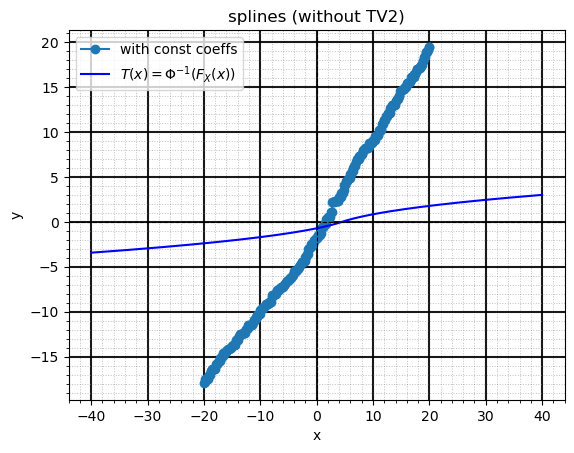

In [18]:
SIZE=301;RANGE=20; START_VAL=-2; END_VAL=10
#GRID_VALS= generate_unequally_spaced_sorted_numbers(start_val=START_VAL,end_val=END_VAL,N=SIZE)
GRID_VALS,FN_INIT = transformation_laplace_to_std_normal(mu=mean, b=scale, x_range=(-RANGE,RANGE), num_points=SIZE)
noise = torch.randn_like(torch.tensor(FN_INIT)) * 2e-1
model2 = LinearSplineSlopeConstrained(
                mode='fc',
                num_activations=1,
                size=SIZE,# number of knots is size -2
                range_=RANGE,
                grid_values=torch.tensor(GRID_VALS),
                # grid_values=torch.tensor([-2.9132, -1.,  1.8,  2.1882,  2.9779]),
                init="manual",#"maxmin",# what if I try relu activation function?
                smin=0.001,
                smax=10,
                slope_constrained=1,
                manual_init_fn_tensor=torch.tensor(FN_INIT)+noise
) 
print("constrained coefficients are: ",model2.slope_constrained_coefficients_vect)
print(f"slopes: constrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
# visualise the code space before the training
input_tensor = torch.tensor(train_data)
output_tensor2=model2(input_tensor)
# plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
#                         ],
#                         labels_list=["data_space (x)","code_space(z)"])

x2pos, y2pos = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()
print('grid vals and x2pos vals')
print(GRID_VALS, x2pos)
print('fn val and slope constrained fn val')
print(FN_INIT, y2pos)
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
plt.figure()
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y",
                    annotate=0, style='-o')
plt.legend()
plt.show()

In [19]:
with torch.no_grad():
   zz,gg=model2(torch.tensor([[-30.], [-20], [0.], [20], [30]])), model2.grad_x_temp
zz,gg, zz**2

(tensor([[-26.8588],
         [-17.9232],
         [ -1.7536],
         [ 19.4655],
         [ 19.4755]], dtype=torch.float64),
 tensor([[0.8936, 0.8936, 0.0010, 0.0010, 0.0010]], dtype=torch.float64),
 tensor([[721.3944],
         [321.2408],
         [  3.0752],
         [378.9064],
         [379.2958]], dtype=torch.float64))

In [20]:
# training 100 rounds with low tv2 regularization
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=100, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.000095,#0.004
    print_after=1,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.001,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1# We don;t need any alpha anymore! get rid of this in the code later
) # why is it no # good thing is that it is shifting but the bad thing is that its kind of collapsing to 0 . NOT ANYMORE

Training Progress:   1%|          | 1/100 [00:09<15:42,  9.52s/it]

Epoch 1/100,  train NLL+0.001XTV2: 38.92323492365452, data avg loss-1: 34.99248619277169 ,data avg loss-2: -3.4678880962152507 ,Training NLL Loss: 38.46037428898698, Validation NLL Loss: 39.666836398400996, LR: 9.5e-05


Training Progress:   2%|▏         | 2/100 [00:19<15:33,  9.53s/it]

Epoch 2/100,  train NLL+0.001XTV2: 35.90022263117936, data avg loss-1: 31.951577449046138 ,data avg loss-2: -3.5091705516922134 ,Training NLL Loss: 35.46074800073838, Validation NLL Loss: 36.56511365270321, LR: 9.5e-05


Training Progress:   3%|▎         | 3/100 [00:28<15:07,  9.36s/it]

Epoch 3/100,  train NLL+0.001XTV2: 33.02364917488342, data avg loss-1: 29.038339463770033 ,data avg loss-2: -3.5680762766236342 ,Training NLL Loss: 32.60641574039363, Validation NLL Loss: 34.025549344618554, LR: 9.5e-05


Training Progress:   4%|▍         | 4/100 [00:37<14:51,  9.29s/it]

Epoch 4/100,  train NLL+0.001XTV2: 30.71077059978656, data avg loss-1: 26.711244500444135 ,data avg loss-2: -3.6017265774022897 ,Training NLL Loss: 30.31297107784646, Validation NLL Loss: 31.532397083660076, LR: 9.5e-05


Training Progress:   5%|▌         | 5/100 [00:46<14:39,  9.25s/it]

Epoch 5/100,  train NLL+0.001XTV2: 28.759629027019358, data avg loss-1: 24.75494997781626 ,data avg loss-2: -3.6231940758576022 ,Training NLL Loss: 28.37814405367388, Validation NLL Loss: 29.61840949314895, LR: 9.5e-05


Training Progress:   6%|▌         | 6/100 [00:55<14:22,  9.18s/it]

Epoch 6/100,  train NLL+0.001XTV2: 26.992897615317492, data avg loss-1: 22.981987072982978 ,data avg loss-2: -3.644921935013069 ,Training NLL Loss: 26.62690900799603, Validation NLL Loss: 28.199978168046545, LR: 9.5e-05


Training Progress:   7%|▋         | 7/100 [01:04<14:04,  9.08s/it]

Epoch 7/100,  train NLL+0.001XTV2: 25.458752431946696, data avg loss-1: 21.437849760520518 ,data avg loss-2: -3.6691370334323734 ,Training NLL Loss: 25.10698679395288, Validation NLL Loss: 26.40532303062201, LR: 9.5e-05


Training Progress:   8%|▊         | 8/100 [01:14<14:09,  9.24s/it]

Epoch 8/100,  train NLL+0.001XTV2: 23.996025291725747, data avg loss-1: 19.92497806789382 ,data avg loss-2: -3.734197792266105 ,Training NLL Loss: 23.65917586015992, Validation NLL Loss: 25.14416522110729, LR: 9.5e-05


Training Progress:   9%|▉         | 9/100 [01:23<13:58,  9.22s/it]

Epoch 9/100,  train NLL+0.001XTV2: 22.737430766696214, data avg loss-1: 18.645059979303962 ,data avg loss-2: -3.7677744121652905 ,Training NLL Loss: 22.41283439146924, Validation NLL Loss: 23.68929799808835, LR: 9.5e-05


Training Progress:  10%|█         | 10/100 [01:32<13:49,  9.21s/it]

Epoch 10/100,  train NLL+0.001XTV2: 21.221210575705285, data avg loss-1: 17.08981663179736 ,data avg loss-2: -3.822374243108271 ,Training NLL Loss: 20.912190874905615, Validation NLL Loss: 22.4089166695551, LR: 9.5e-05


Training Progress:  11%|█         | 11/100 [01:41<13:39,  9.21s/it]

Epoch 11/100,  train NLL+0.001XTV2: 20.2087417097175, data avg loss-1: 16.034162340933346 ,data avg loss-2: -3.8765571959925507 ,Training NLL Loss: 19.910719536925882, Validation NLL Loss: 21.279206009393747, LR: 9.5e-05


Training Progress:  12%|█▏        | 12/100 [01:50<13:31,  9.22s/it]

Epoch 12/100,  train NLL+0.001XTV2: 19.3299307633407, data avg loss-1: 15.170421527089436 ,data avg loss-2: -3.871416012849779 ,Training NLL Loss: 19.041837539939223, Validation NLL Loss: 20.475980529834587, LR: 9.5e-05


Training Progress:  13%|█▎        | 13/100 [02:00<13:25,  9.26s/it]

Epoch 13/100,  train NLL+0.001XTV2: 18.50445741057289, data avg loss-1: 14.337424084285258 ,data avg loss-2: -3.88883447179013 ,Training NLL Loss: 18.226258556075386, Validation NLL Loss: 19.691511148796828, LR: 9.5e-05


Training Progress:  14%|█▍        | 14/100 [02:09<13:16,  9.26s/it]

Epoch 14/100,  train NLL+0.001XTV2: 17.81212439089484, data avg loss-1: 13.67241686869287 ,data avg loss-2: -3.870391136813598 ,Training NLL Loss: 17.54280800550647, Validation NLL Loss: 18.720899151662547, LR: 9.5e-05


Training Progress:  15%|█▌        | 15/100 [02:18<13:07,  9.26s/it]

Epoch 15/100,  train NLL+0.001XTV2: 16.846725050319673, data avg loss-1: 12.662994067910686 ,data avg loss-2: -3.926755306417388 ,Training NLL Loss: 16.589749374328072, Validation NLL Loss: 17.79176612091942, LR: 9.5e-05


Training Progress:  16%|█▌        | 16/100 [02:28<12:57,  9.25s/it]

Epoch 16/100,  train NLL+0.001XTV2: 16.118135764420607, data avg loss-1: 11.98329787187639 ,data avg loss-2: -3.8868818857618193 ,Training NLL Loss: 15.870179757638219, Validation NLL Loss: 17.15710120960778, LR: 9.5e-05


Training Progress:  17%|█▋        | 17/100 [02:37<12:46,  9.24s/it]

Epoch 17/100,  train NLL+0.001XTV2: 15.446878884532918, data avg loss-1: 11.301844251170579 ,data avg loss-2: -3.906958234776814 ,Training NLL Loss: 15.20880248594739, Validation NLL Loss: 16.262272804540842, LR: 9.5e-05


Training Progress:  18%|█▊        | 18/100 [02:46<12:37,  9.24s/it]

Epoch 18/100,  train NLL+0.001XTV2: 14.572157717755204, data avg loss-1: 10.430629136342654 ,data avg loss-2: -3.9161335228487633 ,Training NLL Loss: 14.346762659191425, Validation NLL Loss: 15.484361094791126, LR: 9.5e-05


Training Progress:  19%|█▉        | 19/100 [02:55<12:25,  9.20s/it]

Epoch 19/100,  train NLL+0.001XTV2: 13.902728534640277, data avg loss-1: 9.791163280820939 ,data avg loss-2: -3.89535716844417 ,Training NLL Loss: 13.686520449265105, Validation NLL Loss: 14.65736899864102, LR: 9.5e-05


Training Progress:  20%|██        | 20/100 [03:04<12:14,  9.18s/it]

Epoch 20/100,  train NLL+0.001XTV2: 13.242259847366263, data avg loss-1: 9.152939843532797 ,data avg loss-2: -3.8828164172346677 ,Training NLL Loss: 13.035756260767458, Validation NLL Loss: 14.181816737613923, LR: 9.5e-05


Training Progress:  21%|██        | 21/100 [03:13<12:05,  9.18s/it]

Epoch 21/100,  train NLL+0.001XTV2: 12.816454158082095, data avg loss-1: 8.759759365159828 ,data avg loss-2: -3.857193924048328 ,Training NLL Loss: 12.616953289208157, Validation NLL Loss: 13.67296559665059, LR: 9.5e-05


Training Progress:  22%|██▏       | 22/100 [03:23<11:56,  9.18s/it]

Epoch 22/100,  train NLL+0.001XTV2: 12.322445200333558, data avg loss-1: 8.2954278019759 ,data avg loss-2: -3.835268100934653 ,Training NLL Loss: 12.130695902910539, Validation NLL Loss: 13.163420592579518, LR: 9.5e-05


Training Progress:  23%|██▎       | 23/100 [03:32<11:45,  9.16s/it]

Epoch 23/100,  train NLL+0.001XTV2: 11.915694489514712, data avg loss-1: 7.951309237718312 ,data avg loss-2: -3.779330917181453 ,Training NLL Loss: 11.730640154899756, Validation NLL Loss: 12.701640726343406, LR: 9.5e-05


Training Progress:  24%|██▍       | 24/100 [03:41<11:35,  9.15s/it]

Epoch 24/100,  train NLL+0.001XTV2: 11.382440245181076, data avg loss-1: 7.407434198857474 ,data avg loss-2: -3.7989908779803363 ,Training NLL Loss: 11.206425076837805, Validation NLL Loss: 12.1715818743218, LR: 9.5e-05


Training Progress:  25%|██▌       | 25/100 [03:50<11:24,  9.13s/it]

Epoch 25/100,  train NLL+0.001XTV2: 11.023018380353474, data avg loss-1: 7.0341145812495665 ,data avg loss-2: -3.819683814819441 ,Training NLL Loss: 10.853798396069008, Validation NLL Loss: 11.847759181739168, LR: 9.5e-05


Training Progress:  26%|██▌       | 26/100 [03:59<11:21,  9.21s/it]

Epoch 26/100,  train NLL+0.001XTV2: 10.60821591816327, data avg loss-1: 6.616809309868411 ,data avg loss-2: -3.8303167857300506 ,Training NLL Loss: 10.447126095598463, Validation NLL Loss: 11.39968221331591, LR: 9.5e-05


Training Progress:  27%|██▋       | 27/100 [04:09<11:14,  9.24s/it]

Epoch 27/100,  train NLL+0.001XTV2: 10.27865545355714, data avg loss-1: 6.301996128111888 ,data avg loss-2: -3.8226865694766716 ,Training NLL Loss: 10.124682697588568, Validation NLL Loss: 11.025224230182374, LR: 9.5e-05


Training Progress:  28%|██▊       | 28/100 [04:18<11:01,  9.18s/it]

Epoch 28/100,  train NLL+0.001XTV2: 9.884581238021877, data avg loss-1: 5.9436225975852635 ,data avg loss-2: -3.7943777039962145 ,Training NLL Loss: 9.738000301581478, Validation NLL Loss: 10.629747403605029, LR: 9.5e-05


Training Progress:  29%|██▉       | 29/100 [04:27<10:49,  9.15s/it]

Epoch 29/100,  train NLL+0.001XTV2: 9.556488408442567, data avg loss-1: 5.6351066547554005 ,data avg loss-2: -3.7816712938502652 ,Training NLL Loss: 9.416777948605674, Validation NLL Loss: 10.250099150941688, LR: 9.5e-05


Training Progress:  30%|███       | 30/100 [04:36<10:41,  9.17s/it]

Epoch 30/100,  train NLL+0.001XTV2: 9.272345772802483, data avg loss-1: 5.34337921927402 ,data avg loss-2: -3.7960416434258817 ,Training NLL Loss: 9.139420862699913, Validation NLL Loss: 10.006810470737307, LR: 9.5e-05


Training Progress:  31%|███       | 31/100 [04:45<10:33,  9.18s/it]

Epoch 31/100,  train NLL+0.001XTV2: 8.98912213070466, data avg loss-1: 5.089606836894273 ,data avg loss-2: -3.77205861344442 ,Training NLL Loss: 8.861665450338688, Validation NLL Loss: 9.724020483587264, LR: 9.5e-05


Training Progress:  32%|███▏      | 32/100 [04:54<10:21,  9.14s/it]

Epoch 32/100,  train NLL+0.001XTV2: 8.751053293359032, data avg loss-1: 4.816946591134516 ,data avg loss-2: -3.811896594544641 ,Training NLL Loss: 8.628843185679155, Validation NLL Loss: 9.43499488795639, LR: 9.5e-05


Training Progress:  33%|███▎      | 33/100 [05:03<10:08,  9.08s/it]

Epoch 33/100,  train NLL+0.001XTV2: 8.509171094757477, data avg loss-1: 4.614381786359516 ,data avg loss-2: -3.776753402185286 ,Training NLL Loss: 8.391135188544807, Validation NLL Loss: 9.14187622459468, LR: 9.5e-05


Training Progress:  34%|███▍      | 34/100 [05:12<10:03,  9.15s/it]

Epoch 34/100,  train NLL+0.001XTV2: 8.253412042238272, data avg loss-1: 4.381773927983885 ,data avg loss-2: -3.7588744652846007 ,Training NLL Loss: 8.140648393268487, Validation NLL Loss: 8.923981234738541, LR: 9.5e-05


Training Progress:  35%|███▌      | 35/100 [05:22<09:57,  9.19s/it]

Epoch 35/100,  train NLL+0.001XTV2: 8.015392254555573, data avg loss-1: 4.188028922451768 ,data avg loss-2: -3.719221195193679 ,Training NLL Loss: 7.90725011764544, Validation NLL Loss: 8.615568686511638, LR: 9.5e-05


Training Progress:  36%|███▌      | 36/100 [05:31<09:50,  9.22s/it]

Epoch 36/100,  train NLL+0.001XTV2: 7.727151507811925, data avg loss-1: 3.9911517418686797 ,data avg loss-2: -3.6324409340258565 ,Training NLL Loss: 7.623592675894539, Validation NLL Loss: 8.22089285807893, LR: 9.5e-05


Training Progress:  37%|███▋      | 37/100 [05:40<09:41,  9.23s/it]

Epoch 37/100,  train NLL+0.001XTV2: 7.525324302485988, data avg loss-1: 3.8085237258645326 ,data avg loss-2: -3.617657506596348 ,Training NLL Loss: 7.426181232460884, Validation NLL Loss: 8.08728663857323, LR: 9.5e-05


Training Progress:  38%|███▊      | 38/100 [05:50<09:33,  9.24s/it]

Epoch 38/100,  train NLL+0.001XTV2: 7.255308443888382, data avg loss-1: 3.577356734871355 ,data avg loss-2: -3.5832582339706915 ,Training NLL Loss: 7.160614968842052, Validation NLL Loss: 7.780942219844335, LR: 9.5e-05


Training Progress:  39%|███▉      | 39/100 [05:59<09:22,  9.22s/it]

Epoch 39/100,  train NLL+0.001XTV2: 7.043814763860248, data avg loss-1: 3.354317956863025 ,data avg loss-2: -3.599413058341562 ,Training NLL Loss: 6.953731015204589, Validation NLL Loss: 7.533087143376442, LR: 9.5e-05


Training Progress:  40%|████      | 40/100 [06:08<09:16,  9.28s/it]

Epoch 40/100,  train NLL+0.001XTV2: 6.796748994513096, data avg loss-1: 3.1293422770650463 ,data avg loss-2: -3.5820637553022476 ,Training NLL Loss: 6.711406032367291, Validation NLL Loss: 7.2306866255559585, LR: 9.5e-05


Training Progress:  41%|████      | 41/100 [06:17<09:06,  9.26s/it]

Epoch 41/100,  train NLL+0.001XTV2: 6.581010613253115, data avg loss-1: 2.9111813727109257 ,data avg loss-2: -3.5895258737831943 ,Training NLL Loss: 6.50070724649412, Validation NLL Loss: 6.950958176744636, LR: 9.5e-05


Training Progress:  42%|████▏     | 42/100 [06:27<08:56,  9.25s/it]

Epoch 42/100,  train NLL+0.001XTV2: 6.350677830574061, data avg loss-1: 2.709963163073619 ,data avg loss-2: -3.565388595224799 ,Training NLL Loss: 6.275351758298423, Validation NLL Loss: 6.679410260370007, LR: 9.5e-05


Training Progress:  43%|████▎     | 43/100 [06:36<08:45,  9.21s/it]

Epoch 43/100,  train NLL+0.001XTV2: 6.113010341612879, data avg loss-1: 2.5289834269237548 ,data avg loss-2: -3.5136132842121013 ,Training NLL Loss: 6.0425967111358565, Validation NLL Loss: 6.471115719275692, LR: 9.5e-05


Training Progress:  44%|████▍     | 44/100 [06:45<08:35,  9.20s/it]

Epoch 44/100,  train NLL+0.001XTV2: 5.910528055924111, data avg loss-1: 2.378630324169485 ,data avg loss-2: -3.4658189254054106 ,Training NLL Loss: 5.844449249574901, Validation NLL Loss: 6.181505618060277, LR: 9.5e-05


Training Progress:  45%|████▌     | 45/100 [06:54<08:27,  9.23s/it]

Epoch 45/100,  train NLL+0.001XTV2: 5.653527406218566, data avg loss-1: 2.2466791332497076 ,data avg loss-2: -3.344903733868927 ,Training NLL Loss: 5.5915828671186345, Validation NLL Loss: 5.941910947277798, LR: 9.5e-05


Training Progress:  46%|████▌     | 46/100 [07:03<08:16,  9.19s/it]

Epoch 46/100,  train NLL+0.001XTV2: 5.460239892887113, data avg loss-1: 2.136608610834324 ,data avg loss-2: -3.2659357684722585 ,Training NLL Loss: 5.402544379306586, Validation NLL Loss: 5.829907602908471, LR: 9.5e-05


Training Progress:  47%|████▋     | 47/100 [07:13<08:08,  9.22s/it]

Epoch 47/100,  train NLL+0.001XTV2: 5.278117030113538, data avg loss-1: 2.0296805620774028 ,data avg loss-2: -3.194922534615957 ,Training NLL Loss: 5.224603096693357, Validation NLL Loss: 5.623200834716028, LR: 9.5e-05


Training Progress:  48%|████▊     | 48/100 [07:22<07:58,  9.19s/it]

Epoch 48/100,  train NLL+0.001XTV2: 5.107013088358329, data avg loss-1: 1.9183582534191939 ,data avg loss-2: -3.1390994520934767 ,Training NLL Loss: 5.05745770551267, Validation NLL Loss: 5.414628011914652, LR: 9.5e-05


Training Progress:  49%|████▉     | 49/100 [07:31<07:46,  9.14s/it]

Epoch 49/100,  train NLL+0.001XTV2: 4.971458678931341, data avg loss-1: 1.8232319979215608 ,data avg loss-2: -3.10244422920984 ,Training NLL Loss: 4.925676227131403, Validation NLL Loss: 5.272387703878053, LR: 9.5e-05


Training Progress:  50%|█████     | 50/100 [07:40<07:37,  9.15s/it]

Epoch 50/100,  train NLL+0.001XTV2: 4.816941238784469, data avg loss-1: 1.7481164018242865 ,data avg loss-2: -3.0261888734542493 ,Training NLL Loss: 4.774305275278536, Validation NLL Loss: 5.07858052570076, LR: 9.5e-05


Training Progress:  51%|█████     | 51/100 [07:49<07:30,  9.19s/it]

Epoch 51/100,  train NLL+0.001XTV2: 4.6758057079330895, data avg loss-1: 1.6803569397778597 ,data avg loss-2: -2.9557424564397277 ,Training NLL Loss: 4.636099396217589, Validation NLL Loss: 4.980597279091627, LR: 9.5e-05


Training Progress:  52%|█████▏    | 52/100 [07:58<07:20,  9.17s/it]

Epoch 52/100,  train NLL+0.001XTV2: 4.556741961200413, data avg loss-1: 1.60001695218339 ,data avg loss-2: -2.920004477583205 ,Training NLL Loss: 4.520021429766591, Validation NLL Loss: 4.847539860604474, LR: 9.5e-05


Training Progress:  53%|█████▎    | 53/100 [08:08<07:11,  9.19s/it]

Epoch 53/100,  train NLL+0.001XTV2: 4.457707742322607, data avg loss-1: 1.5432424411374936 ,data avg loss-2: -2.880377113690675 ,Training NLL Loss: 4.423619554828159, Validation NLL Loss: 4.766721840733937, LR: 9.5e-05


Training Progress:  54%|█████▍    | 54/100 [08:17<07:02,  9.18s/it]

Epoch 54/100,  train NLL+0.001XTV2: 4.391293038341802, data avg loss-1: 1.496972035370181 ,data avg loss-2: -2.8625714903066464 ,Training NLL Loss: 4.35954352567683, Validation NLL Loss: 4.6526196045792645, LR: 9.5e-05


Training Progress:  55%|█████▌    | 55/100 [08:26<06:50,  9.12s/it]

Epoch 55/100,  train NLL+0.001XTV2: 4.312880895372239, data avg loss-1: 1.4462964432114453 ,data avg loss-2: -2.8367964755467283 ,Training NLL Loss: 4.283092918758173, Validation NLL Loss: 4.565222692092177, LR: 9.5e-05


Training Progress:  56%|█████▌    | 56/100 [08:35<06:41,  9.12s/it]

Epoch 56/100,  train NLL+0.001XTV2: 4.242345938624652, data avg loss-1: 1.3890311305557392 ,data avg loss-2: -2.8258758902702588 ,Training NLL Loss: 4.214907020825997, Validation NLL Loss: 4.498494947745456, LR: 9.5e-05


Training Progress:  57%|█████▋    | 57/100 [08:44<06:29,  9.06s/it]

Epoch 57/100,  train NLL+0.001XTV2: 4.171668135961507, data avg loss-1: 1.324502236428606 ,data avg loss-2: -2.8218157940524797 ,Training NLL Loss: 4.146318030481083, Validation NLL Loss: 4.416061627590887, LR: 9.5e-05


Training Progress:  58%|█████▊    | 58/100 [08:53<06:21,  9.08s/it]

Epoch 58/100,  train NLL+0.001XTV2: 4.105289398139545, data avg loss-1: 1.2690606826167903 ,data avg loss-2: -2.812740353862892 ,Training NLL Loss: 4.081801036479686, Validation NLL Loss: 4.314943216752999, LR: 9.5e-05


Training Progress:  59%|█████▉    | 59/100 [09:02<06:14,  9.13s/it]

Epoch 59/100,  train NLL+0.001XTV2: 4.036385708927884, data avg loss-1: 1.2290333393520547 ,data avg loss-2: -2.7855210254066676 ,Training NLL Loss: 4.01455436475872, Validation NLL Loss: 4.254684859639349, LR: 9.5e-05


Training Progress:  60%|██████    | 60/100 [09:11<06:05,  9.14s/it]

Epoch 60/100,  train NLL+0.001XTV2: 3.9761418797673422, data avg loss-1: 1.1930236906701837 ,data avg loss-2: -2.762579842521317 ,Training NLL Loss: 3.9556035331915025, Validation NLL Loss: 4.192165092070293, LR: 9.5e-05


Training Progress:  61%|██████    | 61/100 [09:20<05:56,  9.15s/it]

Epoch 61/100,  train NLL+0.001XTV2: 3.926737562158705, data avg loss-1: 1.1482256479264399 ,data avg loss-2: -2.7590137515209596 ,Training NLL Loss: 3.9072393994474, Validation NLL Loss: 4.131847241443063, LR: 9.5e-05


Training Progress:  62%|██████▏   | 62/100 [09:29<05:47,  9.13s/it]

Epoch 62/100,  train NLL+0.001XTV2: 3.904544038861215, data avg loss-1: 1.1086452075375977 ,data avg loss-2: -2.777422179150558 ,Training NLL Loss: 3.886067386688156, Validation NLL Loss: 4.102830686092461, LR: 9.5e-05


Training Progress:  63%|██████▎   | 63/100 [09:39<05:36,  9.10s/it]

Epoch 63/100,  train NLL+0.001XTV2: 3.867358547526349, data avg loss-1: 1.0776386492839733 ,data avg loss-2: -2.772128296387388 ,Training NLL Loss: 3.84976694567136, Validation NLL Loss: 4.029579435511859, LR: 9.5e-05


Training Progress:  64%|██████▍   | 64/100 [09:48<05:27,  9.11s/it]

Epoch 64/100,  train NLL+0.001XTV2: 3.809476001532293, data avg loss-1: 1.0349027434380536 ,data avg loss-2: -2.7578487727650205 ,Training NLL Loss: 3.7927515162030736, Validation NLL Loss: 3.9965924588023216, LR: 9.5e-05


Training Progress:  65%|██████▌   | 65/100 [09:57<05:19,  9.12s/it]

Epoch 65/100,  train NLL+0.001XTV2: 3.796252602278879, data avg loss-1: 1.0037461420125602 ,data avg loss-2: -2.7765653187019192 ,Training NLL Loss: 3.7803114607144814, Validation NLL Loss: 3.960268036072696, LR: 9.5e-05


Training Progress:  66%|██████▌   | 66/100 [10:06<05:09,  9.11s/it]

Epoch 66/100,  train NLL+0.001XTV2: 3.768676061584285, data avg loss-1: 0.9760016052465593 ,data avg loss-2: -2.7775177686826367 ,Training NLL Loss: 3.753519373929198, Validation NLL Loss: 3.940317091754308, LR: 9.5e-05


Training Progress:  67%|██████▋   | 67/100 [10:15<04:59,  9.08s/it]

Epoch 67/100,  train NLL+0.001XTV2: 3.7455397845492624, data avg loss-1: 0.9498983844205037 ,data avg loss-2: -2.781289256083273 ,Training NLL Loss: 3.7311876405037725, Validation NLL Loss: 3.907645793902606, LR: 9.5e-05


Training Progress:  68%|██████▊   | 68/100 [10:24<04:50,  9.08s/it]

Epoch 68/100,  train NLL+0.001XTV2: 3.6846939989794985, data avg loss-1: 0.9120005366558878 ,data avg loss-2: -2.7592521740546205 ,Training NLL Loss: 3.6712527107105064, Validation NLL Loss: 3.8349315119920173, LR: 9.5e-05


Training Progress:  69%|██████▉   | 69/100 [10:33<04:41,  9.08s/it]

Epoch 69/100,  train NLL+0.001XTV2: 3.675960456330054, data avg loss-1: 0.8786018062859678 ,data avg loss-2: -2.784878910365329 ,Training NLL Loss: 3.663480716651297, Validation NLL Loss: 3.8119743760615536, LR: 9.5e-05


Training Progress:  70%|███████   | 70/100 [10:42<04:33,  9.11s/it]

Epoch 70/100,  train NLL+0.001XTV2: 3.66953427439946, data avg loss-1: 0.8542629362128672 ,data avg loss-2: -2.803489265539784 ,Training NLL Loss: 3.657752201752651, Validation NLL Loss: 3.7741428783542923, LR: 9.5e-05


Training Progress:  71%|███████   | 71/100 [10:52<04:27,  9.22s/it]

Epoch 71/100,  train NLL+0.001XTV2: 3.6558532938738577, data avg loss-1: 0.8351881504995635 ,data avg loss-2: -2.809453141862203 ,Training NLL Loss: 3.644641292361764, Validation NLL Loss: 3.7620372578531565, LR: 9.5e-05


Training Progress:  72%|███████▏  | 72/100 [11:01<04:19,  9.27s/it]

Epoch 72/100,  train NLL+0.001XTV2: 3.640628966521957, data avg loss-1: 0.8216446330268877 ,data avg loss-2: -2.8082136728536 ,Training NLL Loss: 3.6298583058804867, Validation NLL Loss: 3.7624755707633777, LR: 9.5e-05


Training Progress:  73%|███████▎  | 73/100 [11:11<04:14,  9.43s/it]

Epoch 73/100,  train NLL+0.001XTV2: 3.617628705850228, data avg loss-1: 0.8082572714734311 ,data avg loss-2: -2.7990058556157384 ,Training NLL Loss: 3.60726312708917, Validation NLL Loss: 3.715921966429282, LR: 9.5e-05


Training Progress:  74%|███████▍  | 74/100 [11:20<04:06,  9.48s/it]

Epoch 74/100,  train NLL+0.001XTV2: 3.56652543651014, data avg loss-1: 0.7899869891087132 ,data avg loss-2: -2.7665408351927705 ,Training NLL Loss: 3.55652782430148, Validation NLL Loss: 3.6705864107792325, LR: 9.5e-05


Training Progress:  75%|███████▌  | 75/100 [11:30<03:56,  9.45s/it]

Epoch 75/100,  train NLL+0.001XTV2: 3.5612086672567345, data avg loss-1: 0.7751651082820104 ,data avg loss-2: -2.776389949821838 ,Training NLL Loss: 3.551555058103851, Validation NLL Loss: 3.639799722164351, LR: 9.5e-05


Training Progress:  76%|███████▌  | 76/100 [11:39<03:44,  9.37s/it]

Epoch 76/100,  train NLL+0.001XTV2: 3.5299126076866867, data avg loss-1: 0.7577259292330606 ,data avg loss-2: -2.7627856164291344 ,Training NLL Loss: 3.5205115456621954, Validation NLL Loss: 3.6377429213929, LR: 9.5e-05


Training Progress:  77%|███████▋  | 77/100 [11:48<03:34,  9.31s/it]

Epoch 77/100,  train NLL+0.001XTV2: 3.4969615571078028, data avg loss-1: 0.7417710116698215 ,data avg loss-2: -2.74609028156886 ,Training NLL Loss: 3.4878612932386788, Validation NLL Loss: 3.587338746215841, LR: 9.5e-05


Training Progress:  78%|███████▊  | 78/100 [11:57<03:24,  9.29s/it]

Epoch 78/100,  train NLL+0.001XTV2: 3.4970670488518008, data avg loss-1: 0.7373053913729891 ,data avg loss-2: -2.7509829151185983 ,Training NLL Loss: 3.488288306491584, Validation NLL Loss: 3.6208802265149918, LR: 9.5e-05


Training Progress:  79%|███████▉  | 79/100 [12:07<03:14,  9.28s/it]

Epoch 79/100,  train NLL+0.001XTV2: 3.4932111807644373, data avg loss-1: 0.7273613459465583 ,data avg loss-2: -2.757416093196742 ,Training NLL Loss: 3.484777439143297, Validation NLL Loss: 3.5672670073726453, LR: 9.5e-05


Training Progress:  80%|████████  | 80/100 [12:16<03:05,  9.28s/it]

Epoch 80/100,  train NLL+0.001XTV2: 3.455038125041439, data avg loss-1: 0.7012569209032338 ,data avg loss-2: -2.745718904350208 ,Training NLL Loss: 3.446975825253441, Validation NLL Loss: 3.5122982951447526, LR: 9.5e-05


Training Progress:  81%|████████  | 81/100 [12:25<02:56,  9.28s/it]

Epoch 81/100,  train NLL+0.001XTV2: 3.416971624989036, data avg loss-1: 0.6749325320315797 ,data avg loss-2: -2.734297967845851 ,Training NLL Loss: 3.4092304998774345, Validation NLL Loss: 3.4759001168822246, LR: 9.5e-05


Training Progress:  82%|████████▏ | 82/100 [12:34<02:46,  9.24s/it]

Epoch 82/100,  train NLL+0.001XTV2: 3.3845911665307975, data avg loss-1: 0.6654284683038547 ,data avg loss-2: -2.7117408888000316 ,Training NLL Loss: 3.377169357103889, Validation NLL Loss: 3.4608221319825088, LR: 9.5e-05


Training Progress:  83%|████████▎ | 83/100 [12:44<02:36,  9.23s/it]

Epoch 83/100,  train NLL+0.001XTV2: 3.355970999900178, data avg loss-1: 0.6478068379139682 ,data avg loss-2: -2.7009765934315606 ,Training NLL Loss: 3.348783431345524, Validation NLL Loss: 3.446013140009471, LR: 9.5e-05


Training Progress:  84%|████████▍ | 84/100 [12:53<02:27,  9.25s/it]

Epoch 84/100,  train NLL+0.001XTV2: 3.340385626932718, data avg loss-1: 0.6354255425137716 ,data avg loss-2: -2.698029002133274 ,Training NLL Loss: 3.3334545446470436, Validation NLL Loss: 3.430488129638435, LR: 9.5e-05


Training Progress:  85%|████████▌ | 85/100 [13:02<02:17,  9.17s/it]

Epoch 85/100,  train NLL+0.001XTV2: 3.333792816574146, data avg loss-1: 0.6182199409875632 ,data avg loss-2: -2.7088560017532086 ,Training NLL Loss: 3.3270759427407683, Validation NLL Loss: 3.4218454991775564, LR: 9.5e-05


Training Progress:  86%|████████▌ | 86/100 [13:12<02:10,  9.29s/it]

Epoch 86/100,  train NLL+0.001XTV2: 3.324330973780313, data avg loss-1: 0.6083557202339764 ,data avg loss-2: -2.7094679230800085 ,Training NLL Loss: 3.317823643313985, Validation NLL Loss: 3.402733064981317, LR: 9.5e-05


Training Progress:  87%|████████▋ | 87/100 [13:21<02:00,  9.29s/it]

Epoch 87/100,  train NLL+0.001XTV2: 3.2986130770951827, data avg loss-1: 0.5970297602993702 ,data avg loss-2: -2.695253185982433 ,Training NLL Loss: 3.292282946281805, Validation NLL Loss: 3.3624453095394515, LR: 9.5e-05


Training Progress:  88%|████████▊ | 88/100 [13:30<01:50,  9.23s/it]

Epoch 88/100,  train NLL+0.001XTV2: 3.2822882317389217, data avg loss-1: 0.5872540625248858 ,data avg loss-2: -2.6888791530778113 ,Training NLL Loss: 3.2761332156026994, Validation NLL Loss: 3.362844987493587, LR: 9.5e-05


Training Progress:  89%|████████▉ | 89/100 [13:39<01:41,  9.19s/it]

Epoch 89/100,  train NLL+0.001XTV2: 3.248562409297368, data avg loss-1: 0.5740016983784185 ,data avg loss-2: -2.6685902035364024 ,Training NLL Loss: 3.2425919019148197, Validation NLL Loss: 3.2882332521226716, LR: 9.5e-05


Training Progress:  90%|█████████ | 90/100 [13:48<01:32,  9.23s/it]

Epoch 90/100,  train NLL+0.001XTV2: 3.2067536672965105, data avg loss-1: 0.5712292021784106 ,data avg loss-2: -2.629740785893549 ,Training NLL Loss: 3.2009699880719595, Validation NLL Loss: 3.2883414180208677, LR: 9.5e-05


Training Progress:  91%|█████████ | 91/100 [13:58<01:23,  9.23s/it]

Epoch 91/100,  train NLL+0.001XTV2: 3.184218182002875, data avg loss-1: 0.5628328778745024 ,data avg loss-2: -2.6157417527840536 ,Training NLL Loss: 3.1785746306585567, Validation NLL Loss: 3.231023876860324, LR: 9.5e-05


Training Progress:  92%|█████████▏| 92/100 [14:07<01:14,  9.32s/it]

Epoch 92/100,  train NLL+0.001XTV2: 3.146567762180722, data avg loss-1: 0.5577464551253084 ,data avg loss-2: -2.5833565384394626 ,Training NLL Loss: 3.141102993564772, Validation NLL Loss: 3.2117637036475166, LR: 9.5e-05


Training Progress:  93%|█████████▎| 93/100 [14:16<01:05,  9.34s/it]

Epoch 93/100,  train NLL+0.001XTV2: 3.12463227209816, data avg loss-1: 0.5462277335193256 ,data avg loss-2: -2.573064488706659 ,Training NLL Loss: 3.1192922222259845, Validation NLL Loss: 3.201165281816235, LR: 9.5e-05


Training Progress:  94%|█████████▍| 94/100 [14:26<00:55,  9.31s/it]

Epoch 94/100,  train NLL+0.001XTV2: 3.1025535459105944, data avg loss-1: 0.5364794645642927 ,data avg loss-2: -2.560851012231158 ,Training NLL Loss: 3.097330476795452, Validation NLL Loss: 3.1851699126218715, LR: 9.5e-05


Training Progress:  95%|█████████▌| 95/100 [14:35<00:46,  9.36s/it]

Epoch 95/100,  train NLL+0.001XTV2: 3.1091435028389722, data avg loss-1: 0.5257228471918834 ,data avg loss-2: -2.578326361112357 ,Training NLL Loss: 3.104049208304242, Validation NLL Loss: 3.1887107592171153, LR: 9.5e-05


Training Progress:  96%|█████████▌| 96/100 [14:44<00:37,  9.35s/it]

Epoch 96/100,  train NLL+0.001XTV2: 3.098287251084608, data avg loss-1: 0.5202169884472536 ,data avg loss-2: -2.5731782095534372 ,Training NLL Loss: 3.093395198000692, Validation NLL Loss: 3.1479389539213156, LR: 9.5e-05


Training Progress:  97%|█████████▋| 97/100 [14:54<00:27,  9.31s/it]

Epoch 97/100,  train NLL+0.001XTV2: 3.0437433785146686, data avg loss-1: 0.5215143867822487 ,data avg loss-2: -2.5175464125681604 ,Training NLL Loss: 3.0390607993504086, Validation NLL Loss: 2.9869539734293276, LR: 9.5e-05


Training Progress:  98%|█████████▊| 98/100 [15:03<00:18,  9.27s/it]

Epoch 98/100,  train NLL+0.001XTV2: 3.041477209954779, data avg loss-1: 0.5128688029773781 ,data avg loss-2: -2.5241520035103955 ,Training NLL Loss: 3.037020806487773, Validation NLL Loss: 3.146311856617606, LR: 9.5e-05


Training Progress:  99%|█████████▉| 99/100 [15:12<00:09,  9.26s/it]

Epoch 99/100,  train NLL+0.001XTV2: 3.0192654081964454, data avg loss-1: 0.509649994085164 ,data avg loss-2: -2.505338024949994 ,Training NLL Loss: 3.014988019035157, Validation NLL Loss: 3.0923658438068653, LR: 9.5e-05


Training Progress: 100%|██████████| 100/100 [15:21<00:00,  9.22s/it]

Epoch 100/100,  train NLL+0.001XTV2: 2.9962101287390457, data avg loss-1: 0.5096563626977714 ,data avg loss-2: -2.4824897914888875 ,Training NLL Loss: 2.9921461541866567, Validation NLL Loss: 3.077207226127191, LR: 9.5e-05
Training complete


In [21]:
# plot different plots to visualise the training dynamics
def analyse_training(model_in, test_data,train_loss, val_loss,model_params_list,
                    num_coeffs ,figsize=(12,12),num_samples=20000,
                    print_model_params=0, plot_freq=5
                    ):
    input_tensor = torch.tensor(test_data)
    output_tensor2 = model_in(input_tensor)
    plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()],
                            labels_list=["original_space (x)", "code_space(z)"])

    plot_loss_curves(train_loss=train_loss, val_loss=val_loss,
                    title="linear-spline model slope constrained", log_scale=1)

    x2pos, y2pos = model_in.nodal_val_loc_tensor.detach().numpy(), model_in.slope_constrained_coefficients_vect.detach().numpy()
    # Add labels, title, and grid
    # plt.figure(figsize=(8,8))
    
    plot_with_annotations(x2pos[0][:], y2pos[:],
                        title="splines (without TV2)", xlabel="x", ylabel="y", annotate=0, style="-*")
    plt.legend()
    plt.show()
    ## 
    print(f"slopes: constrained coeffs: {model_in.slopes_tensor(for_projected_coeffs=1)}")
    #plot_coefficients_evolution(num_coeffs,
    #                            np.array(coeffs_unconstrained_evol2), 
    #                            np.array(coeffs_const_evol2), log_scale=0)
    
    model = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        grid_values=model_in.nodal_val_loc_tensor.detach().reshape(-1),
                        init="maxmin",#"maxmin",# what if I try relu activation function?
                        smin=0.01,
                        smax=2,
                        slope_constrained=1
) 
    
    plot_multiple_z_with_normal_1d(models_params=model_params_list,test_data=test_data,
                                model=model,figsize=figsize, num_samples=num_samples,
                                print_model_params=print_model_params, plot_frequency=plot_freq)


In [22]:
# need to run thhis code further from here
x2pos2, y2pos2 = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()

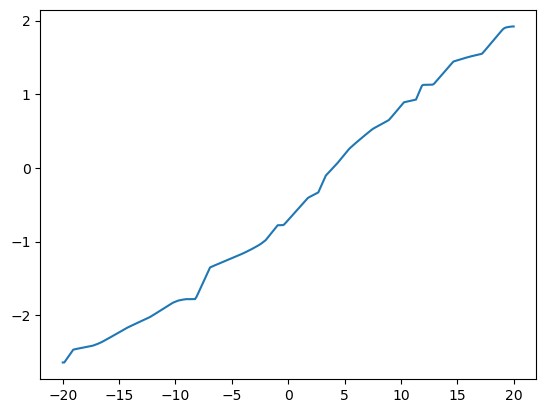

In [23]:
plt.plot(x2pos2[0], y2pos2)

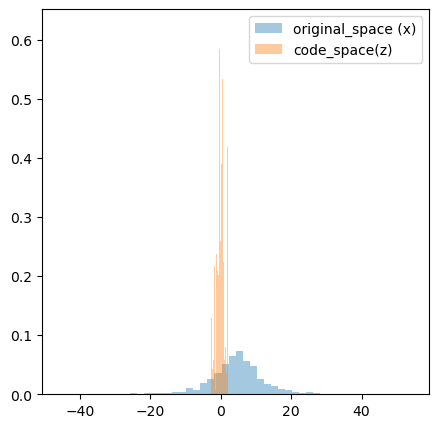

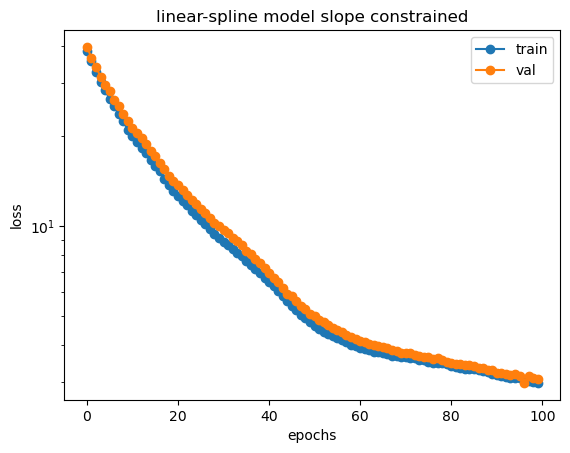

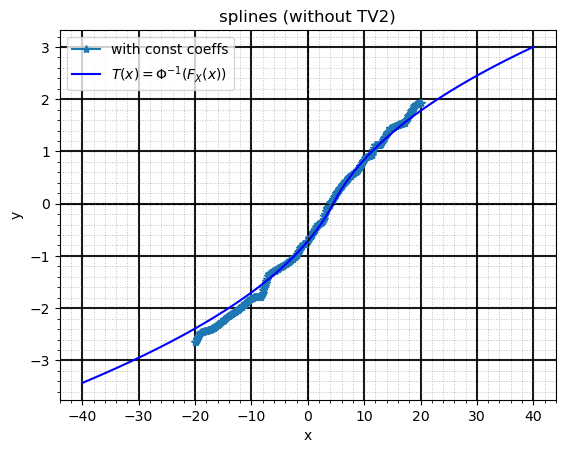

slopes: constrained coeffs: tensor([[0.0010, 0.0010, 0.2169, 0.2178, 0.2179, 0.2179, 0.2175, 0.2173, 0.0395,
         0.0301, 0.0299, 0.0296, 0.0294, 0.0291, 0.0294, 0.0289, 0.0291, 0.0294,
         0.0313, 0.0339, 0.0352, 0.0535, 0.0579, 0.0585, 0.0644, 0.0677, 0.0741,
         0.0777, 0.0838, 0.0841, 0.0842, 0.0864, 0.0863, 0.0868, 0.0877, 0.0879,
         0.0882, 0.0881, 0.0880, 0.0870, 0.0863, 0.0862, 0.0851, 0.0845, 0.0774,
         0.0735, 0.0711, 0.0707, 0.0698, 0.0696, 0.0700, 0.0693, 0.0696, 0.0703,
         0.0704, 0.0706, 0.0722, 0.0735, 0.0797, 0.0911, 0.0932, 0.0958, 0.0960,
         0.0969, 0.0972, 0.0973, 0.0976, 0.0974, 0.0970, 0.0969, 0.0969, 0.0962,
         0.0940, 0.0882, 0.0762, 0.0596, 0.0587, 0.0562, 0.0342, 0.0314, 0.0282,
         0.0262, 0.0178, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.2340,
         0.3241, 0.3332, 0.3356, 0.3362, 0.3359, 0.3356, 0.3354, 0.3338, 0.3198,
         0.0706, 0.0656, 0.0657, 0.0642, 0.0639, 0.0638, 0.0638, 0.0633, 0.0633,


/home/neel/Desktop/Lipschitz_DSNN/activations/linearspline_slope_constraint.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


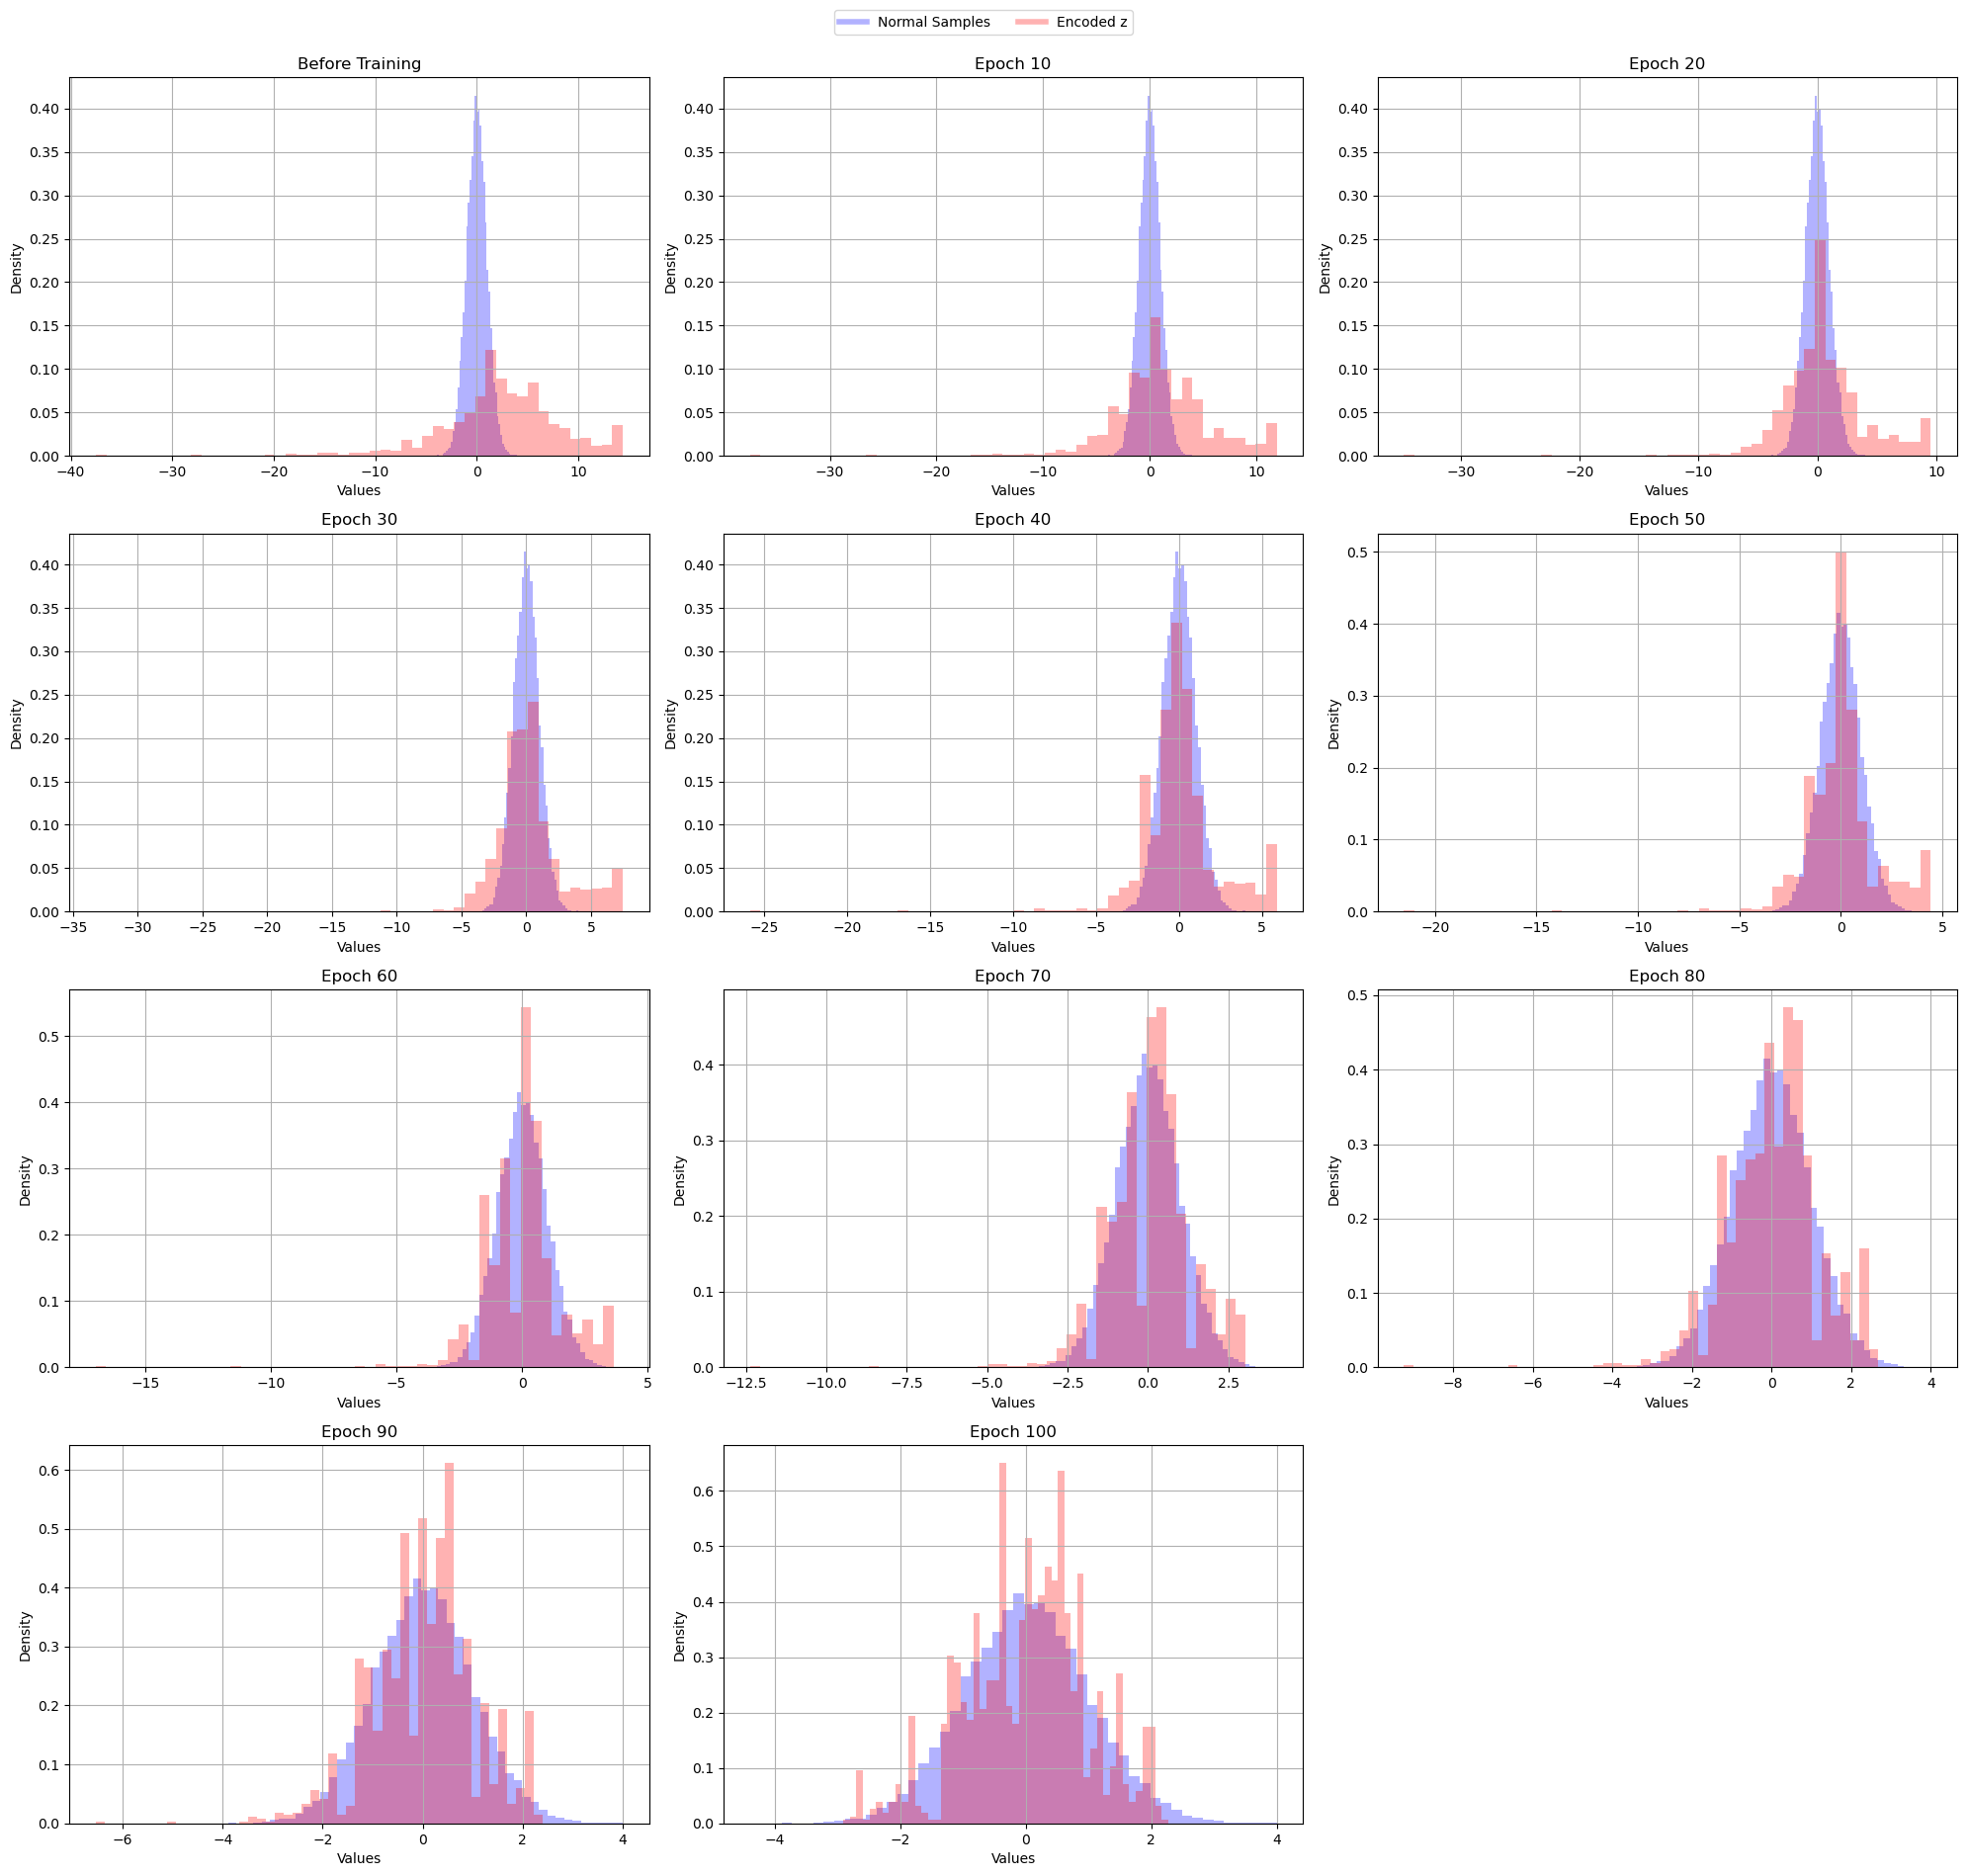

In [24]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=test_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=10) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)

In [25]:
from scipy.interpolate import CubicSpline

In [26]:
def create_spline_interpolator(x, y, kind='cubic'):
    """
    Creates an interpolation function based on given x and y values.
    
    Parameters:
    - x: array-like, input x values.
    - y: array-like, corresponding y values.
    - kind: str, type of interpolation ('linear', 'quadratic', 'cubic').
    
    Returns:
    - interp_function: function that takes new x values and returns interpolated y values.
    """
    if kind == 'cubic':
        interp_function = CubicSpline(x, y)
    else:
        from scipy.interpolate import interp1d
        interp_function = interp1d(x, y, kind=kind, fill_value="extrapolate")
    
    return interp_function  # This function can now be used for new x values

In [27]:
xdata, ydata = model2.nodal_val_loc_tensor.detach().numpy(), model2.slope_constrained_coefficients_vect.detach().numpy()

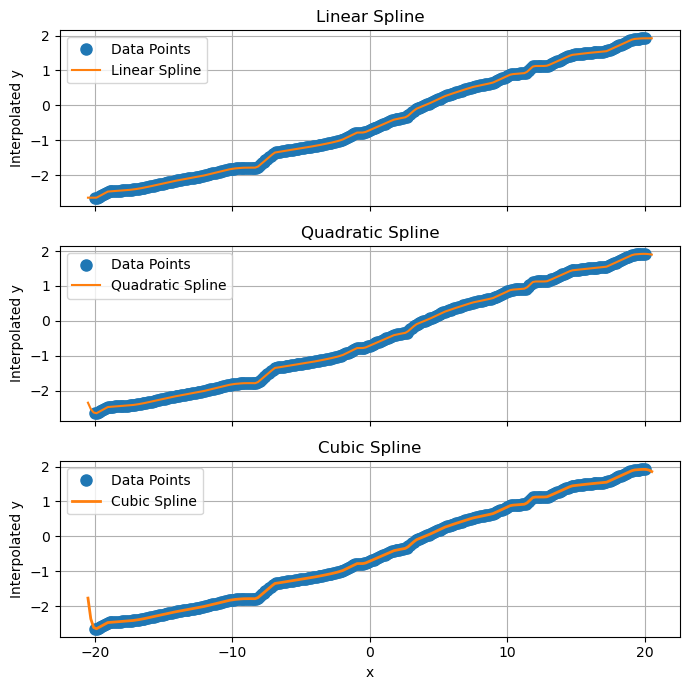

In [28]:
from scipy.interpolate import interp1d, CubicSpline

def create_spline_interpolators(x, y):
    """
    Creates linear, quadratic, and cubic spline interpolators.

    Parameters:
    - x: array-like, input x values.
    - y: array-like, corresponding y values.

    Returns:
    - Dictionary containing interpolation functions for each kind.
    """
    inter_fns = {
        'linear': interp1d(x, y, kind='linear', fill_value="extrapolate"),
        'quadratic': interp1d(x, y, kind='quadratic', fill_value="extrapolate"),
        'cubic': CubicSpline(x, y)  # Equivalent to interp1d with kind='cubic'
    }
    return inter_fns

# Get interpolators
interpolators = create_spline_interpolators(xdata[0], ydata)

# Generate dense x values for smooth plotting
x_dense = np.linspace(xdata.min() - 0.5, xdata.max() + 0.5, 200)

# Compute interpolated values for each method
y_linear = interpolators['linear'](x_dense)
y_quadratic = interpolators['quadratic'](x_dense)
y_cubic = interpolators['cubic'](x_dense)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# Linear Spline
axes[0].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[0].plot(x_dense, y_linear, '-', label='Linear Spline', linewidth=1.5)
axes[0].set_ylabel("Interpolated y")
axes[0].set_title("Linear Spline")
axes[0].legend()
axes[0].grid(True)

# Quadratic Spline
axes[1].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[1].plot(x_dense, y_quadratic, '-', label='Quadratic Spline', linewidth=1.5)
axes[1].set_ylabel("Interpolated y")
axes[1].set_title("Quadratic Spline")
axes[1].legend()
axes[1].grid(True)

# Cubic Spline
axes[2].plot(xdata[0], ydata, 'o', label='Data Points', markersize=8)
axes[2].plot(x_dense, y_cubic, '-', label='Cubic Spline', linewidth=2)
axes[2].set_xlabel("x")
axes[2].set_ylabel("Interpolated y")
axes[2].set_title("Cubic Spline")
axes[2].legend()
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [29]:
interpolators

{'linear': <scipy.interpolate._interpolate.interp1d at 0x7e44b97f8ea0>,
 'quadratic': <scipy.interpolate._interpolate.interp1d at 0x7e44b979e2c0>,
 'cubic': <scipy.interpolate._cubic.CubicSpline at 0x7e44fca2c4f0>}

In [30]:
y_lin, y_quad, y_cubic = interpolators['linear'](test_data), interpolators['quadratic'](test_data), interpolators['cubic'](test_data)
with torch.no_grad():
    model_op = model2(torch.tensor(test_data, dtype=torch.float))

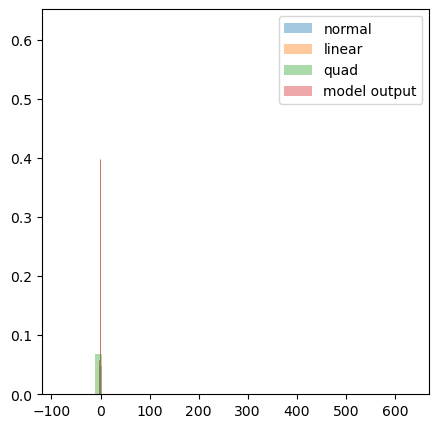

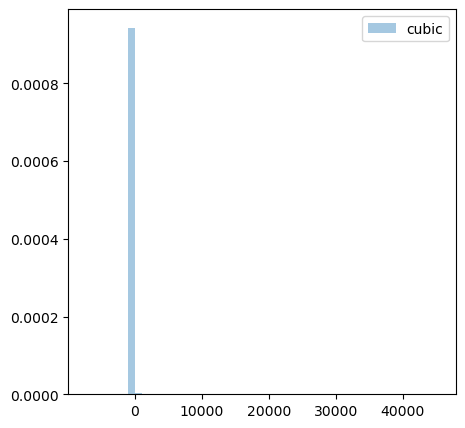

In [31]:
plot_multiple_histogram([np.random.normal(0, 1, num_samples), 
                        y_lin,
                        y_quad, 
                        #y_cubic,
                        model_op.squeeze().numpy()
                        ],
                        labels_list=["normal", 
                                     "linear",
                                     "quad", 
                                     #"cubic",
                                     "model output"
                                     ])

plot_multiple_histogram([ 
                        y_cubic
             
                        ],
                        labels_list=[
                                     "cubic"
               
                                     ])

In [32]:
# 2ND TIME training 100 more rounds
train_loss2, val_loss2, epoch_wise_param_list,coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=100, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.000095,#0.004
    print_after=1,   
    track_coefficients=1, #
    type_model="scls", 
    tv2_regulation= 1, 
    lambda_tv2=0.001,#0.095, 
    gamma = 0.5, # schedular, learning rate decay factor
    alpha_nll=1
) 

Training Progress:   1%|          | 1/100 [00:09<15:26,  9.36s/it]

Epoch 1/100,  train NLL+0.001XTV2: 2.9736626542635416, data avg loss-1: 0.5096400771964186 ,data avg loss-2: -2.4601609073220936 ,Training NLL Loss: 2.9698009845185114, Validation NLL Loss: 3.0432205481941383, LR: 9.5e-05


Training Progress:   2%|▏         | 2/100 [00:18<15:10,  9.29s/it]

Epoch 2/100,  train NLL+0.001XTV2: 2.9539524456345747, data avg loss-1: 0.5075290224433034 ,data avg loss-2: -2.442748990093629 ,Training NLL Loss: 2.950278012536932, Validation NLL Loss: 3.0213430489024375, LR: 9.5e-05


Training Progress:   3%|▎         | 3/100 [00:27<15:00,  9.28s/it]

Epoch 3/100,  train NLL+0.001XTV2: 2.9272621559654883, data avg loss-1: 0.5071589425355442 ,data avg loss-2: -2.4165664304740626 ,Training NLL Loss: 2.9237253730096042, Validation NLL Loss: 3.056937937870714, LR: 9.5e-05


Training Progress:   4%|▍         | 4/100 [00:37<14:47,  9.24s/it]

Epoch 4/100,  train NLL+0.001XTV2: 2.9657080091046333, data avg loss-1: 0.5011708256601264 ,data avg loss-2: -2.461169767604967 ,Training NLL Loss: 2.9623405932650932, Validation NLL Loss: 3.0591352746818523, LR: 9.5e-05


Training Progress:   5%|▌         | 5/100 [00:46<14:41,  9.28s/it]

Epoch 5/100,  train NLL+0.001XTV2: 2.966886965723815, data avg loss-1: 0.49719373962075525 ,data avg loss-2: -2.466481076685767 ,Training NLL Loss: 2.963674816306521, Validation NLL Loss: 3.0584766940496655, LR: 9.5e-05


Training Progress:   6%|▌         | 6/100 [00:55<14:30,  9.26s/it]

Epoch 6/100,  train NLL+0.001XTV2: 2.9614560586014256, data avg loss-1: 0.49544997363431964 ,data avg loss-2: -2.462917413303596 ,Training NLL Loss: 2.9583673869379155, Validation NLL Loss: 3.041473148140265, LR: 4.75e-05


Training Progress:   7%|▋         | 7/100 [01:04<14:21,  9.26s/it]

Epoch 7/100,  train NLL+0.001XTV2: 2.948936415401413, data avg loss-1: 0.4934595485974119 ,data avg loss-2: -2.4524959039034235 ,Training NLL Loss: 2.945955452500835, Validation NLL Loss: 3.03338373240398, LR: 4.75e-05


Training Progress:   8%|▊         | 8/100 [01:14<14:11,  9.26s/it]

Epoch 8/100,  train NLL+0.001XTV2: 2.9398879803401723, data avg loss-1: 0.492612253954061 ,data avg loss-2: -2.4443556366934347 ,Training NLL Loss: 2.9369678906474967, Validation NLL Loss: 3.028150637201125, LR: 4.75e-05


Training Progress:   9%|▉         | 9/100 [01:23<14:03,  9.27s/it]

Epoch 9/100,  train NLL+0.001XTV2: 2.927704800169605, data avg loss-1: 0.49186909696300873 ,data avg loss-2: -2.4329737589212415 ,Training NLL Loss: 2.9248428558842505, Validation NLL Loss: 2.9931591541842733, LR: 2.375e-05


Training Progress:  10%|█         | 10/100 [01:32<13:53,  9.27s/it]

Epoch 10/100,  train NLL+0.001XTV2: 2.9178831612571763, data avg loss-1: 0.4920767968908309 ,data avg loss-2: -2.4229960285484657 ,Training NLL Loss: 2.9150728254392964, Validation NLL Loss: 2.9909953553165907, LR: 2.375e-05


Training Progress:  11%|█         | 11/100 [01:42<13:48,  9.31s/it]

Epoch 11/100,  train NLL+0.001XTV2: 2.9145892953288737, data avg loss-1: 0.4919924834645857 ,data avg loss-2: -2.4198219490688837 ,Training NLL Loss: 2.9118144325334705, Validation NLL Loss: 2.9932718078766474, LR: 2.375e-05


Training Progress:  12%|█▏        | 12/100 [01:51<13:44,  9.37s/it]

Epoch 12/100,  train NLL+0.001XTV2: 2.9158688513678244, data avg loss-1: 0.49160639360621605 ,data avg loss-2: -2.4215162067237315 ,Training NLL Loss: 2.9131226003299475, Validation NLL Loss: 2.9907691564205203, LR: 2.375e-05


Training Progress:  13%|█▎        | 13/100 [02:00<13:31,  9.32s/it]

Epoch 13/100,  train NLL+0.001XTV2: 2.9108978956181524, data avg loss-1: 0.4915631499334339 ,data avg loss-2: -2.4166144464672663 ,Training NLL Loss: 2.908177596400702, Validation NLL Loss: 2.900923801309806, LR: 2.375e-05


Training Progress:  14%|█▍        | 14/100 [02:09<13:17,  9.28s/it]

Epoch 14/100,  train NLL+0.001XTV2: 2.8754269744836662, data avg loss-1: 0.4923812909856536 ,data avg loss-2: -2.38035728325753 ,Training NLL Loss: 2.872738574243184, Validation NLL Loss: 2.994964452004564, LR: 2.375e-05


Training Progress:  15%|█▌        | 15/100 [02:18<12:59,  9.18s/it]

Epoch 15/100,  train NLL+0.001XTV2: 2.9131924090065775, data avg loss-1: 0.49090793615292566 ,data avg loss-2: -2.4196187443507435 ,Training NLL Loss: 2.9105266805036716, Validation NLL Loss: 2.981877356726976, LR: 2.375e-05


Training Progress:  16%|█▌        | 16/100 [02:27<12:45,  9.11s/it]

Epoch 16/100,  train NLL+0.001XTV2: 2.908897562370985, data avg loss-1: 0.4906134897831624 ,data avg loss-2: -2.415646398420603 ,Training NLL Loss: 2.906259888203765, Validation NLL Loss: 2.9825301952333656, LR: 2.375e-05


Training Progress:  17%|█▋        | 17/100 [02:37<12:39,  9.15s/it]

Epoch 17/100,  train NLL+0.001XTV2: 2.9084746779412884, data avg loss-1: 0.49031960708742656 ,data avg loss-2: -2.4155462764488673 ,Training NLL Loss: 2.9058658835362965, Validation NLL Loss: 2.9853111731655715, LR: 1.1875e-05


Training Progress:  18%|█▊        | 18/100 [02:46<12:32,  9.18s/it]

Epoch 18/100,  train NLL+0.001XTV2: 2.9070433375610567, data avg loss-1: 0.4900961149744369 ,data avg loss-2: -2.4143657291365566 ,Training NLL Loss: 2.904461844110994, Validation NLL Loss: 2.9822490736448004, LR: 1.1875e-05


Training Progress:  19%|█▉        | 19/100 [02:55<12:22,  9.17s/it]

Epoch 19/100,  train NLL+0.001XTV2: 2.9065338041834794, data avg loss-1: 0.48999670373863735 ,data avg loss-2: -2.4139706272315524 ,Training NLL Loss: 2.9039673309701888, Validation NLL Loss: 2.979797392963058, LR: 1.1875e-05


Training Progress:  20%|██        | 20/100 [03:04<12:19,  9.24s/it]

Epoch 20/100,  train NLL+0.001XTV2: 2.9049403760924775, data avg loss-1: 0.48988223949815035 ,data avg loss-2: -2.412507916789351 ,Training NLL Loss: 2.9023901562874976, Validation NLL Loss: 2.981545785466065, LR: 5.9375e-06


Training Progress:  21%|██        | 21/100 [03:13<12:06,  9.19s/it]

Epoch 21/100,  train NLL+0.001XTV2: 2.9079057069768797, data avg loss-1: 0.48954843533499776 ,data avg loss-2: -2.4158211477160614 ,Training NLL Loss: 2.9053695830510597, Validation NLL Loss: 2.9861118376617592, LR: 5.9375e-06


Training Progress:  22%|██▏       | 22/100 [03:22<11:51,  9.12s/it]

Epoch 22/100,  train NLL+0.001XTV2: 2.9075279182310014, data avg loss-1: 0.4894355843675127 ,data avg loss-2: -2.41556518882593 ,Training NLL Loss: 2.9050007731934406, Validation NLL Loss: 2.9846405776284346, LR: 5.9375e-06


Training Progress:  23%|██▎       | 23/100 [03:31<11:38,  9.07s/it]

Epoch 23/100,  train NLL+0.001XTV2: 2.907406081036201, data avg loss-1: 0.48929388463304635 ,data avg loss-2: -2.4155937661088194 ,Training NLL Loss: 2.904887650741865, Validation NLL Loss: 2.9822285187207105, LR: 2.96875e-06


Training Progress:  24%|██▍       | 24/100 [03:40<11:26,  9.04s/it]

Epoch 24/100,  train NLL+0.001XTV2: 2.9050795944077463, data avg loss-1: 0.48933401169403884 ,data avg loss-2: -2.4132335112098477 ,Training NLL Loss: 2.9025675229038876, Validation NLL Loss: 2.9810060669753464, LR: 2.96875e-06


Training Progress:  25%|██▌       | 25/100 [03:49<11:17,  9.03s/it]

Epoch 25/100,  train NLL+0.001XTV2: 2.9045117626210026, data avg loss-1: 0.48930922556099227 ,data avg loss-2: -2.4126939819022373 ,Training NLL Loss: 2.902003207463227, Validation NLL Loss: 2.9814923720018602, LR: 2.96875e-06


Training Progress:  26%|██▌       | 26/100 [03:58<11:06,  9.01s/it]

Epoch 26/100,  train NLL+0.001XTV2: 2.903863058137058, data avg loss-1: 0.4893044687882672 ,data avg loss-2: -2.4120535621872827 ,Training NLL Loss: 2.9013580309755462, Validation NLL Loss: 2.9793786987579383, LR: 1.484375e-06


Training Progress:  27%|██▋       | 27/100 [04:07<10:57,  9.01s/it]

Epoch 27/100,  train NLL+0.001XTV2: 2.903371919653801, data avg loss-1: 0.4892957861825225 ,data avg loss-2: -2.411574750486523 ,Training NLL Loss: 2.9008705366690477, Validation NLL Loss: 2.979512705399611, LR: 1.484375e-06


Training Progress:  28%|██▊       | 28/100 [04:17<10:52,  9.06s/it]

Epoch 28/100,  train NLL+0.001XTV2: 2.903301895107741, data avg loss-1: 0.4892913521165612 ,data avg loss-2: -2.4115110189761753 ,Training NLL Loss: 2.9008023710927393, Validation NLL Loss: 2.979850164207892, LR: 1.484375e-06


Training Progress:  29%|██▉       | 29/100 [04:26<10:43,  9.06s/it]

Epoch 29/100,  train NLL+0.001XTV2: 2.903568799514109, data avg loss-1: 0.48927139287216953 ,data avg loss-2: -2.411799702857661 ,Training NLL Loss: 2.901071095729831, Validation NLL Loss: 2.980284382916869, LR: 7.421875e-07


Training Progress:  30%|███       | 30/100 [04:35<10:37,  9.11s/it]

Epoch 30/100,  train NLL+0.001XTV2: 2.9028937660063017, data avg loss-1: 0.4892582495415419 ,data avg loss-2: -2.4111396323178194 ,Training NLL Loss: 2.9003978818593614, Validation NLL Loss: 2.9809137300238646, LR: 7.421875e-07


Training Progress:  31%|███       | 31/100 [04:44<10:32,  9.16s/it]

Epoch 31/100,  train NLL+0.001XTV2: 2.904261088483774, data avg loss-1: 0.48922903392233713 ,data avg loss-2: -2.4125372417534345 ,Training NLL Loss: 2.9017662756757745, Validation NLL Loss: 2.9807162283391024, LR: 7.421875e-07


Training Progress:  32%|███▏      | 32/100 [04:54<10:30,  9.28s/it]

Epoch 32/100,  train NLL+0.001XTV2: 2.904726376961334, data avg loss-1: 0.4892128936865156 ,data avg loss-2: -2.4130195839605544 ,Training NLL Loss: 2.9022324776470683, Validation NLL Loss: 2.981629241057272, LR: 3.7109375e-07


Training Progress:  33%|███▎      | 33/100 [05:03<10:26,  9.36s/it]

Epoch 33/100,  train NLL+0.001XTV2: 2.904937328100731, data avg loss-1: 0.48920142832193636 ,data avg loss-2: -2.4132429041494423 ,Training NLL Loss: 2.902444332471378, Validation NLL Loss: 2.9817865840744284, LR: 3.7109375e-07


Training Progress:  34%|███▍      | 34/100 [05:13<10:25,  9.48s/it]

Epoch 34/100,  train NLL+0.001XTV2: 2.9049523295961377, data avg loss-1: 0.4891961195988845 ,data avg loss-2: -2.4132637741260288 ,Training NLL Loss: 2.9024598937249135, Validation NLL Loss: 2.9815614948056854, LR: 3.7109375e-07


Training Progress:  35%|███▌      | 35/100 [05:23<10:22,  9.58s/it]

Epoch 35/100,  train NLL+0.001XTV2: 2.9050473741812284, data avg loss-1: 0.4891901935211715 ,data avg loss-2: -2.41336517051833 ,Training NLL Loss: 2.9025553640395056, Validation NLL Loss: 2.981775981451641, LR: 1.85546875e-07


Training Progress:  36%|███▌      | 36/100 [05:33<10:17,  9.64s/it]

Epoch 36/100,  train NLL+0.001XTV2: 2.904989628698787, data avg loss-1: 0.4891883588608608 ,data avg loss-2: -2.413309648634471 ,Training NLL Loss: 2.9024980074953333, Validation NLL Loss: 2.98198152697598, LR: 1.85546875e-07


Training Progress:  37%|███▋      | 37/100 [05:42<10:10,  9.69s/it]

Epoch 37/100,  train NLL+0.001XTV2: 2.905104378636509, data avg loss-1: 0.4891853755089995 ,data avg loss-2: -2.4134276420012073 ,Training NLL Loss: 2.9026130175102054, Validation NLL Loss: 2.9820573145117044, LR: 1.85546875e-07


Training Progress:  38%|███▊      | 38/100 [05:52<10:01,  9.70s/it]

Epoch 38/100,  train NLL+0.001XTV2: 2.905055293144293, data avg loss-1: 0.4891859947362356 ,data avg loss-2: -2.413378190275531 ,Training NLL Loss: 2.9025641850117663, Validation NLL Loss: 2.981904729920771, LR: 9.27734375e-08


Training Progress:  39%|███▉      | 39/100 [06:01<09:46,  9.61s/it]

Epoch 39/100,  train NLL+0.001XTV2: 2.905055575355676, data avg loss-1: 0.4891849126307702 ,data avg loss-2: -2.413379779251996 ,Training NLL Loss: 2.9025646918827683, Validation NLL Loss: 2.9819711565508857, LR: 9.27734375e-08


Training Progress:  40%|████      | 40/100 [06:11<09:31,  9.52s/it]

Epoch 40/100,  train NLL+0.001XTV2: 2.905071366794376, data avg loss-1: 0.48918427920691315 ,data avg loss-2: -2.4133963450895184 ,Training NLL Loss: 2.902580624296432, Validation NLL Loss: 2.981979594441802, LR: 9.27734375e-08


Training Progress:  41%|████      | 41/100 [06:20<09:18,  9.46s/it]

Epoch 41/100,  train NLL+0.001XTV2: 2.905123480777725, data avg loss-1: 0.4891817297766717 ,data avg loss-2: -2.4134511536058287 ,Training NLL Loss: 2.9026328833824984, Validation NLL Loss: 2.9820198468015704, LR: 4.638671875e-08


Training Progress:  42%|████▏     | 42/100 [06:29<09:04,  9.39s/it]

Epoch 42/100,  train NLL+0.001XTV2: 2.9051106198264356, data avg loss-1: 0.4891814463670128 ,data avg loss-2: -2.413438687671236 ,Training NLL Loss: 2.9026201340382456, Validation NLL Loss: 2.9819899563208754, LR: 4.638671875e-08


Training Progress:  43%|████▎     | 43/100 [06:38<08:51,  9.32s/it]

Epoch 43/100,  train NLL+0.001XTV2: 2.9051258531462825, data avg loss-1: 0.4891806448209722 ,data avg loss-2: -2.413454793220512 ,Training NLL Loss: 2.902635438041485, Validation NLL Loss: 2.9820656180117897, LR: 4.638671875e-08


Training Progress:  44%|████▍     | 44/100 [06:48<08:43,  9.35s/it]

Epoch 44/100,  train NLL+0.001XTV2: 2.905176275672528, data avg loss-1: 0.4891791894962352 ,data avg loss-2: -2.4135067308324683 ,Training NLL Loss: 2.902685920328704, Validation NLL Loss: 2.9821346180810475, LR: 2.3193359375e-08


Training Progress:  45%|████▌     | 45/100 [06:57<08:32,  9.33s/it]

Epoch 45/100,  train NLL+0.001XTV2: 2.9051583569176636, data avg loss-1: 0.48917898602086884 ,data avg loss-2: -2.413489071909293 ,Training NLL Loss: 2.902668057930165, Validation NLL Loss: 2.9818286821768036, LR: 2.3193359375e-08


Training Progress:  46%|████▌     | 46/100 [07:06<08:19,  9.25s/it]

Epoch 46/100,  train NLL+0.001XTV2: 2.9048417553399757, data avg loss-1: 0.48918333896844507 ,data avg loss-2: -2.4131681938303156 ,Training NLL Loss: 2.9023515327987597, Validation NLL Loss: 2.9816432010666043, LR: 2.3193359375e-08


Training Progress:  47%|████▋     | 47/100 [07:15<08:09,  9.24s/it]

Epoch 47/100,  train NLL+0.001XTV2: 2.9048982996717525, data avg loss-1: 0.48918245163755086 ,data avg loss-2: -2.413225648764076 ,Training NLL Loss: 2.9024081004016264, Validation NLL Loss: 2.9817796114265778, LR: 1.15966796875e-08


Training Progress:  48%|████▊     | 48/100 [07:25<07:59,  9.22s/it]

Epoch 48/100,  train NLL+0.001XTV2: 2.904943211304803, data avg loss-1: 0.48918138225539226 ,data avg loss-2: -2.413271651209679 ,Training NLL Loss: 2.902453033465074, Validation NLL Loss: 2.9818561597162945, LR: 1.15966796875e-08


Training Progress:  49%|████▉     | 49/100 [07:34<07:49,  9.21s/it]

Epoch 49/100,  train NLL+0.001XTV2: 2.90500712646531, data avg loss-1: 0.48918032170813536 ,data avg loss-2: -2.4133366342269973 ,Training NLL Loss: 2.9025169559351336, Validation NLL Loss: 2.9819108521284687, LR: 1.15966796875e-08


Training Progress:  50%|█████     | 50/100 [07:43<07:44,  9.29s/it]

Epoch 50/100,  train NLL+0.001XTV2: 2.9050457383252537, data avg loss-1: 0.48917954877577585 ,data avg loss-2: -2.4133760311564263 ,Training NLL Loss: 2.902555579932206, Validation NLL Loss: 2.9819767660861323, LR: 1.15966796875e-08


Training Progress:  51%|█████     | 51/100 [07:53<07:36,  9.31s/it]

Epoch 51/100,  train NLL+0.001XTV2: 2.905099645152206, data avg loss-1: 0.4891786371570896 ,data avg loss-2: -2.413430857517643 ,Training NLL Loss: 2.902609494674735, Validation NLL Loss: 2.9820472027331504, LR: 1.15966796875e-08


Training Progress:  52%|█████▏    | 52/100 [08:02<07:27,  9.33s/it]

Epoch 52/100,  train NLL+0.001XTV2: 2.905143343503419, data avg loss-1: 0.4891779382307591 ,data avg loss-2: -2.413475263548954 ,Training NLL Loss: 2.902653201779715, Validation NLL Loss: 2.982086980086865, LR: 1.15966796875e-08


Training Progress:  53%|█████▎    | 53/100 [08:12<07:20,  9.37s/it]

Epoch 53/100,  train NLL+0.001XTV2: 2.905142727251066, data avg loss-1: 0.48917767544195123 ,data avg loss-2: -2.4134749271871545 ,Training NLL Loss: 2.902652602629105, Validation NLL Loss: 2.9820636430205725, LR: 1.15966796875e-08


Training Progress:  54%|█████▍    | 54/100 [08:21<07:09,  9.33s/it]

Epoch 54/100,  train NLL+0.001XTV2: 2.9051503951673903, data avg loss-1: 0.489177440273887 ,data avg loss-2: -2.413482845056288 ,Training NLL Loss: 2.9026602853301755, Validation NLL Loss: 2.982113399939567, LR: 1.15966796875e-08


Training Progress:  55%|█████▌    | 55/100 [08:30<06:58,  9.30s/it]

Epoch 55/100,  train NLL+0.001XTV2: 2.905185336371925, data avg loss-1: 0.4891767655139557 ,data avg loss-2: -2.4135184707723654 ,Training NLL Loss: 2.902695236286323, Validation NLL Loss: 2.982161551827226, LR: 1.15966796875e-08


Training Progress:  56%|█████▌    | 56/100 [08:39<06:49,  9.30s/it]

Epoch 56/100,  train NLL+0.001XTV2: 2.9052104272916046, data avg loss-1: 0.48917625964514483 ,data avg loss-2: -2.4135440788504834 ,Training NLL Loss: 2.9027203384956275, Validation NLL Loss: 2.9821554147033487, LR: 1.15966796875e-08


Training Progress:  57%|█████▋    | 57/100 [08:48<06:37,  9.24s/it]

Epoch 57/100,  train NLL+0.001XTV2: 2.9052058291816425, data avg loss-1: 0.48917632644113335 ,data avg loss-2: -2.4135394333665996 ,Training NLL Loss: 2.902715759807733, Validation NLL Loss: 2.9821620937085385, LR: 1.15966796875e-08


Training Progress:  58%|█████▊    | 58/100 [08:58<06:29,  9.28s/it]

Epoch 58/100,  train NLL+0.001XTV2: 2.9052384849334123, data avg loss-1: 0.4891756909865127 ,data avg loss-2: -2.4135727354368677 ,Training NLL Loss: 2.9027484264233805, Validation NLL Loss: 2.9822117548744447, LR: 1.15966796875e-08


Training Progress:  59%|█████▉    | 59/100 [09:07<06:19,  9.25s/it]

Epoch 59/100,  train NLL+0.001XTV2: 2.90526646720058, data avg loss-1: 0.4891752604142485 ,data avg loss-2: -2.4136011564346838 ,Training NLL Loss: 2.902776416848934, Validation NLL Loss: 2.9822362864593597, LR: 1.15966796875e-08


Training Progress:  60%|██████    | 60/100 [09:16<06:12,  9.32s/it]

Epoch 60/100,  train NLL+0.001XTV2: 2.905267561977129, data avg loss-1: 0.48917497903797247 ,data avg loss-2: -2.413602546895952 ,Training NLL Loss: 2.902777525933924, Validation NLL Loss: 2.982236230113625, LR: 1.15966796875e-08


Training Progress:  61%|██████    | 61/100 [09:26<06:05,  9.36s/it]

Epoch 61/100,  train NLL+0.001XTV2: 2.9052744710522433, data avg loss-1: 0.48917473189513455 ,data avg loss-2: -2.4136097194413217 ,Training NLL Loss: 2.902784451336453, Validation NLL Loss: 2.982216569925978, LR: 1.15966796875e-08


Training Progress:  62%|██████▏   | 62/100 [09:35<05:54,  9.32s/it]

Epoch 62/100,  train NLL+0.001XTV2: 2.9052602494608895, data avg loss-1: 0.48917481960164766 ,data avg loss-2: -2.4135954263411468 ,Training NLL Loss: 2.9027702459427944, Validation NLL Loss: 2.9822260232896776, LR: 1.15966796875e-08


Training Progress:  63%|██████▎   | 63/100 [09:44<05:42,  9.25s/it]

Epoch 63/100,  train NLL+0.001XTV2: 2.9052710792482115, data avg loss-1: 0.4891745968188075 ,data avg loss-2: -2.413606490729126 ,Training NLL Loss: 2.9027810875479347, Validation NLL Loss: 2.982262475027142, LR: 1.15966796875e-08


Training Progress:  64%|██████▍   | 64/100 [09:53<05:30,  9.17s/it]

Epoch 64/100,  train NLL+0.001XTV2: 2.9052864736100146, data avg loss-1: 0.4891743421149594 ,data avg loss-2: -2.41362214961225 ,Training NLL Loss: 2.902796491727208, Validation NLL Loss: 2.9822517127593025, LR: 1.15966796875e-08


Training Progress:  65%|██████▌   | 65/100 [10:02<05:20,  9.14s/it]

Epoch 65/100,  train NLL+0.001XTV2: 2.9052761810292935, data avg loss-1: 0.4891743655985572 ,data avg loss-2: -2.413611849868028 ,Training NLL Loss: 2.902786215466585, Validation NLL Loss: 2.9822439898657986, LR: 1.15966796875e-08


Training Progress:  66%|██████▌   | 66/100 [10:11<05:10,  9.14s/it]

Epoch 66/100,  train NLL+0.001XTV2: 2.9052783674060185, data avg loss-1: 0.4891741933599036 ,data avg loss-2: -2.413614224011879 ,Training NLL Loss: 2.902788417371783, Validation NLL Loss: 2.9822587066771424, LR: 1.15966796875e-08


Training Progress:  67%|██████▋   | 67/100 [10:21<05:05,  9.24s/it]

Epoch 67/100,  train NLL+0.001XTV2: 2.9052003453085398, data avg loss-1: 0.48917501728449664 ,data avg loss-2: -2.4135353956663104 ,Training NLL Loss: 2.9027104129508072, Validation NLL Loss: 2.9821144208069823, LR: 1.15966796875e-08


Training Progress:  68%|██████▊   | 68/100 [10:30<04:56,  9.27s/it]

Epoch 68/100,  train NLL+0.001XTV2: 2.905289905696265, data avg loss-1: 0.4891737032132387 ,data avg loss-2: -2.413626281020437 ,Training NLL Loss: 2.902799984233676, Validation NLL Loss: 2.9822675518490653, LR: 1.15966796875e-08


Training Progress:  69%|██████▉   | 69/100 [10:40<04:47,  9.28s/it]

Epoch 69/100,  train NLL+0.001XTV2: 2.9052908332434852, data avg loss-1: 0.48917356811835305 ,data avg loss-2: -2.4136273579955967 ,Training NLL Loss: 2.902800926113951, Validation NLL Loss: 2.9822528615204167, LR: 1.15966796875e-08


Training Progress:  70%|███████   | 70/100 [10:49<04:38,  9.27s/it]

Epoch 70/100,  train NLL+0.001XTV2: 2.905257711280034, data avg loss-1: 0.489173921129225 ,data avg loss-2: -2.4135939035309963 ,Training NLL Loss: 2.902767824660218, Validation NLL Loss: 2.9822237195417722, LR: 1.15966796875e-08


Training Progress:  71%|███████   | 71/100 [10:58<04:27,  9.23s/it]

Epoch 71/100,  train NLL+0.001XTV2: 2.9052886533037485, data avg loss-1: 0.48917332207326436 ,data avg loss-2: -2.4136254550754064 ,Training NLL Loss: 2.9027987771486723, Validation NLL Loss: 2.982301660755382, LR: 1.15966796875e-08


Training Progress:  72%|███████▏  | 72/100 [11:07<04:18,  9.23s/it]

Epoch 72/100,  train NLL+0.001XTV2: 2.9053202809094856, data avg loss-1: 0.489172846808399 ,data avg loss-2: -2.413657567295824 ,Training NLL Loss: 2.9028304141042227, Validation NLL Loss: 2.982312601771206, LR: 1.15966796875e-08


Training Progress:  73%|███████▎  | 73/100 [11:16<04:09,  9.26s/it]

Epoch 73/100,  train NLL+0.001XTV2: 2.905323829617869, data avg loss-1: 0.4891727521061752 ,data avg loss-2: -2.4136612260519654 ,Training NLL Loss: 2.9028339781581414, Validation NLL Loss: 2.982305228727404, LR: 1.15966796875e-08


Training Progress:  74%|███████▍  | 74/100 [11:26<04:00,  9.26s/it]

Epoch 74/100,  train NLL+0.001XTV2: 2.905318321650538, data avg loss-1: 0.4891728179117949 ,data avg loss-2: -2.413655665352124 ,Training NLL Loss: 2.902828483263918, Validation NLL Loss: 2.9822976171897557, LR: 1.15966796875e-08


Training Progress:  75%|███████▌  | 75/100 [11:35<03:51,  9.25s/it]

Epoch 75/100,  train NLL+0.001XTV2: 2.9053102341594457, data avg loss-1: 0.4891728614801698 ,data avg loss-2: -2.4136475473418164 ,Training NLL Loss: 2.9028204088219858, Validation NLL Loss: 2.9822903294935865, LR: 1.15966796875e-08


Training Progress:  76%|███████▌  | 76/100 [11:44<03:42,  9.27s/it]

Epoch 76/100,  train NLL+0.001XTV2: 2.905312667291028, data avg loss-1: 0.4891726576632777 ,data avg loss-2: -2.4136501974997717 ,Training NLL Loss: 2.9028228551630484, Validation NLL Loss: 2.9822941055338696, LR: 1.15966796875e-08


Training Progress:  77%|███████▋  | 77/100 [11:54<03:33,  9.28s/it]

Epoch 77/100,  train NLL+0.001XTV2: 2.905304013159657, data avg loss-1: 0.48917275403336785 ,data avg loss-2: -2.413641460961497 ,Training NLL Loss: 2.902814214994864, Validation NLL Loss: 2.9822700840231433, LR: 1.15966796875e-08


Training Progress:  78%|███████▊  | 78/100 [12:03<03:24,  9.28s/it]

Epoch 78/100,  train NLL+0.001XTV2: 2.9052955782792367, data avg loss-1: 0.4891728051468983 ,data avg loss-2: -2.413632989120986 ,Training NLL Loss: 2.902805794267885, Validation NLL Loss: 2.9822779819383305, LR: 1.15966796875e-08


Training Progress:  79%|███████▉  | 79/100 [12:12<03:14,  9.25s/it]

Epoch 79/100,  train NLL+0.001XTV2: 2.9053048658504785, data avg loss-1: 0.48917244350713346 ,data avg loss-2: -2.413642652023102 ,Training NLL Loss: 2.9028150955302343, Validation NLL Loss: 2.9822913055091886, LR: 1.15966796875e-08


Training Progress:  80%|████████  | 80/100 [12:21<03:04,  9.23s/it]

Epoch 80/100,  train NLL+0.001XTV2: 2.9053002682983418, data avg loss-1: 0.4891724286008626 ,data avg loss-2: -2.413638082427722 ,Training NLL Loss: 2.902810511028588, Validation NLL Loss: 2.9822688023147674, LR: 1.15966796875e-08


Training Progress:  81%|████████  | 81/100 [12:30<02:55,  9.23s/it]

Epoch 81/100,  train NLL+0.001XTV2: 2.9052882145874217, data avg loss-1: 0.48917252178319814 ,data avg loss-2: -2.413625951254532 ,Training NLL Loss: 2.902798473037728, Validation NLL Loss: 2.982258553822718, LR: 1.15966796875e-08


Training Progress:  82%|████████▏ | 82/100 [12:40<02:46,  9.23s/it]

Epoch 82/100,  train NLL+0.001XTV2: 2.905278716689473, data avg loss-1: 0.4891725236234312 ,data avg loss-2: -2.4136164652739787 ,Training NLL Loss: 2.9027889888974094, Validation NLL Loss: 2.98224112831406, LR: 1.15966796875e-08


Training Progress:  83%|████████▎ | 83/100 [12:49<02:37,  9.24s/it]

Epoch 83/100,  train NLL+0.001XTV2: 2.905268634181933, data avg loss-1: 0.48917265464074594 ,data avg loss-2: -2.4136062661686575 ,Training NLL Loss: 2.9027789208094035, Validation NLL Loss: 2.982240487145964, LR: 1.15966796875e-08


Training Progress:  84%|████████▍ | 84/100 [12:58<02:28,  9.27s/it]

Epoch 84/100,  train NLL+0.001XTV2: 2.9052733556939487, data avg loss-1: 0.4891723884763209 ,data avg loss-2: -2.4136112699303673 ,Training NLL Loss: 2.9027836584066904, Validation NLL Loss: 2.982248726382387, LR: 1.15966796875e-08


Training Progress:  85%|████████▌ | 85/100 [13:07<02:18,  9.26s/it]

Epoch 85/100,  train NLL+0.001XTV2: 2.905271377972471, data avg loss-1: 0.4891723816994139 ,data avg loss-2: -2.4136093128578486 ,Training NLL Loss: 2.9027816945572624, Validation NLL Loss: 2.9822358716516337, LR: 1.15966796875e-08


Training Progress:  86%|████████▌ | 86/100 [13:16<02:08,  9.19s/it]

Epoch 86/100,  train NLL+0.001XTV2: 2.9052601065339174, data avg loss-1: 0.48917241865104155 ,data avg loss-2: -2.4135980183496955 ,Training NLL Loss: 2.902770437000737, Validation NLL Loss: 2.9822325455814203, LR: 1.15966796875e-08


Training Progress:  87%|████████▋ | 87/100 [13:26<01:58,  9.13s/it]

Epoch 87/100,  train NLL+0.001XTV2: 2.9052658871075834, data avg loss-1: 0.4891721014479463 ,data avg loss-2: -2.413604131368879 ,Training NLL Loss: 2.9027762328168274, Validation NLL Loss: 2.9822309684271753, LR: 1.15966796875e-08


Training Progress:  88%|████████▊ | 88/100 [13:34<01:49,  9.09s/it]

Epoch 88/100,  train NLL+0.001XTV2: 2.905269997137444, data avg loss-1: 0.4891718593818711 ,data avg loss-2: -2.4136085008499473 ,Training NLL Loss: 2.9027803602318194, Validation NLL Loss: 2.98224157780201, LR: 1.15966796875e-08


Training Progress:  89%|████████▉ | 89/100 [13:44<01:40,  9.14s/it]

Epoch 89/100,  train NLL+0.001XTV2: 2.9052672508267516, data avg loss-1: 0.4891717817848884 ,data avg loss-2: -2.413605845820028 ,Training NLL Loss: 2.902777627604917, Validation NLL Loss: 2.982233889288718, LR: 1.15966796875e-08


Training Progress:  90%|█████████ | 90/100 [13:53<01:31,  9.17s/it]

Epoch 90/100,  train NLL+0.001XTV2: 2.9052225326275485, data avg loss-1: 0.48917210823030544 ,data avg loss-2: -2.413560816779055 ,Training NLL Loss: 2.9027329250093583, Validation NLL Loss: 2.9822465272797856, LR: 1.15966796875e-08


Training Progress:  91%|█████████ | 91/100 [14:02<01:22,  9.18s/it]

Epoch 91/100,  train NLL+0.001XTV2: 2.905276956175775, data avg loss-1: 0.4891711754609329 ,data avg loss-2: -2.413616184861251 ,Training NLL Loss: 2.9027873603221845, Validation NLL Loss: 2.982260979568769, LR: 1.15966796875e-08


Training Progress:  92%|█████████▏| 92/100 [14:11<01:13,  9.20s/it]

Epoch 92/100,  train NLL+0.001XTV2: 2.9052833691114395, data avg loss-1: 0.4891708411458815 ,data avg loss-2: -2.413622945995326 ,Training NLL Loss: 2.9027937871412077, Validation NLL Loss: 2.9822661079710535, LR: 1.15966796875e-08


Training Progress:  93%|█████████▎| 93/100 [14:21<01:05,  9.32s/it]

Epoch 93/100,  train NLL+0.001XTV2: 2.905287138819554, data avg loss-1: 0.4891705785934954 ,data avg loss-2: -2.4136269922575946 ,Training NLL Loss: 2.902797570851092, Validation NLL Loss: 2.982272866121581, LR: 1.15966796875e-08


Training Progress:  94%|█████████▍| 94/100 [14:31<00:56,  9.44s/it]

Epoch 94/100,  train NLL+0.001XTV2: 2.9053000666679254, data avg loss-1: 0.4891702401491951 ,data avg loss-2: -2.4136402710432963 ,Training NLL Loss: 2.9028105111924907, Validation NLL Loss: 2.98228746678426, LR: 1.15966796875e-08


Training Progress:  95%|█████████▌| 95/100 [14:41<00:47,  9.55s/it]

Epoch 95/100,  train NLL+0.001XTV2: 2.90524841056858, data avg loss-1: 0.48917077089440225 ,data avg loss-2: -2.4135881044563408 ,Training NLL Loss: 2.902758875350741, Validation NLL Loss: 2.982216316242483, LR: 1.15966796875e-08


Training Progress:  96%|█████████▌| 96/100 [14:50<00:38,  9.61s/it]

Epoch 96/100,  train NLL+0.001XTV2: 2.9052818663449154, data avg loss-1: 0.48917037775578176 ,data avg loss-2: -2.413621964561138 ,Training NLL Loss: 2.9027923423169173, Validation NLL Loss: 2.982318495982574, LR: 1.15966796875e-08


Training Progress:  97%|█████████▋| 97/100 [15:00<00:28,  9.65s/it]

Epoch 97/100,  train NLL+0.001XTV2: 2.905330096963779, data avg loss-1: 0.48916948541986455 ,data avg loss-2: -2.4136710968125117 ,Training NLL Loss: 2.902840582232376, Validation NLL Loss: 2.9822436313359453, LR: 1.15966796875e-08


Training Progress:  98%|█████████▊| 98/100 [15:10<00:19,  9.71s/it]

Epoch 98/100,  train NLL+0.001XTV2: 2.9053189501759484, data avg loss-1: 0.4891693838768876 ,data avg loss-2: -2.413660065513546 ,Training NLL Loss: 2.9028294493904356, Validation NLL Loss: 2.9823294413532175, LR: 1.15966796875e-08


Training Progress:  99%|█████████▉| 99/100 [15:19<00:09,  9.64s/it]

Epoch 99/100,  train NLL+0.001XTV2: 2.9053391738257446, data avg loss-1: 0.48916891594097034 ,data avg loss-2: -2.413680771997095 ,Training NLL Loss: 2.902849687938067, Validation NLL Loss: 2.9823483426291904, LR: 1.15966796875e-08


Training Progress: 100%|██████████| 100/100 [15:29<00:00,  9.30s/it]

Epoch 100/100,  train NLL+0.001XTV2: 2.905348852904786, data avg loss-1: 0.4891684880438098 ,data avg loss-2: -2.413690893522554 ,Training NLL Loss: 2.9028593815663624, Validation NLL Loss: 2.9823574247441496, LR: 1.15966796875e-08
Training complete


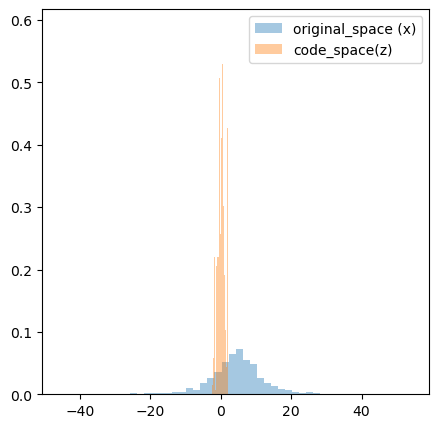

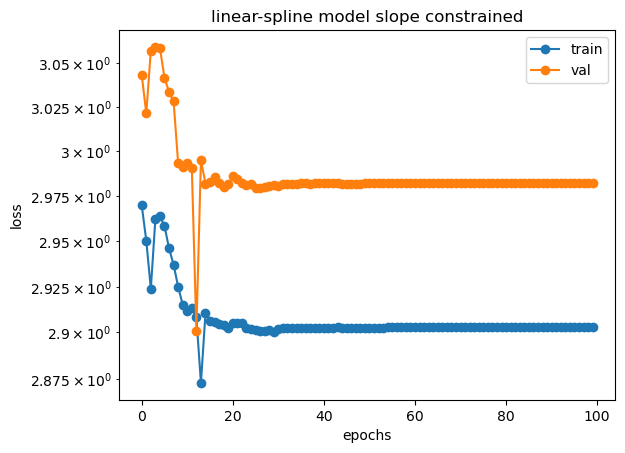

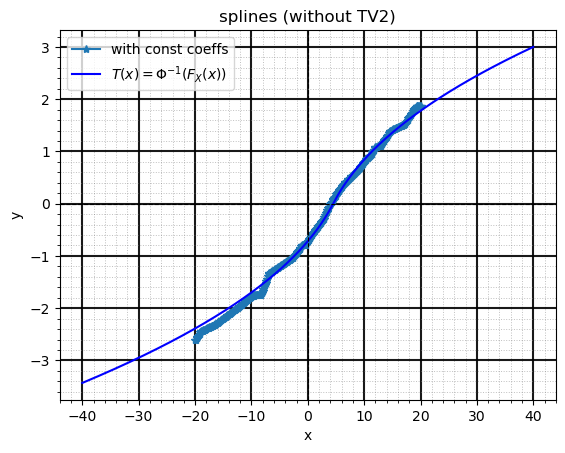

slopes: constrained coeffs: tensor([[0.0010, 0.0010, 0.1755, 0.1755, 0.1755, 0.1755, 0.1755, 0.1755, 0.1532,
         0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495,
         0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0495, 0.0604, 0.0746,
         0.0750, 0.0780, 0.0781, 0.0785, 0.0791, 0.0795, 0.0795, 0.0796, 0.0796,
         0.0796, 0.0797, 0.0799, 0.0799, 0.0799, 0.0799, 0.0800, 0.0800, 0.0800,
         0.0801, 0.0801, 0.0801, 0.0801, 0.0802, 0.0803, 0.0803, 0.0804, 0.0806,
         0.0808, 0.0810, 0.0816, 0.0834, 0.0849, 0.0869, 0.0873, 0.0873, 0.0873,
         0.0873, 0.0873, 0.0873, 0.0873, 0.0873, 0.0873, 0.0873, 0.0873, 0.0873,
         0.0873, 0.0873, 0.0873, 0.0870, 0.0714, 0.0452, 0.0398, 0.0332, 0.0166,
         0.0016, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.2977,
         0.2977, 0.2977, 0.2977, 0.2977, 0.2977, 0.2977, 0.2977, 0.2977, 0.2977,
         0.1876, 0.0790, 0.0681, 0.0681, 0.0681, 0.0681, 0.0681, 0.0681, 0.0681,


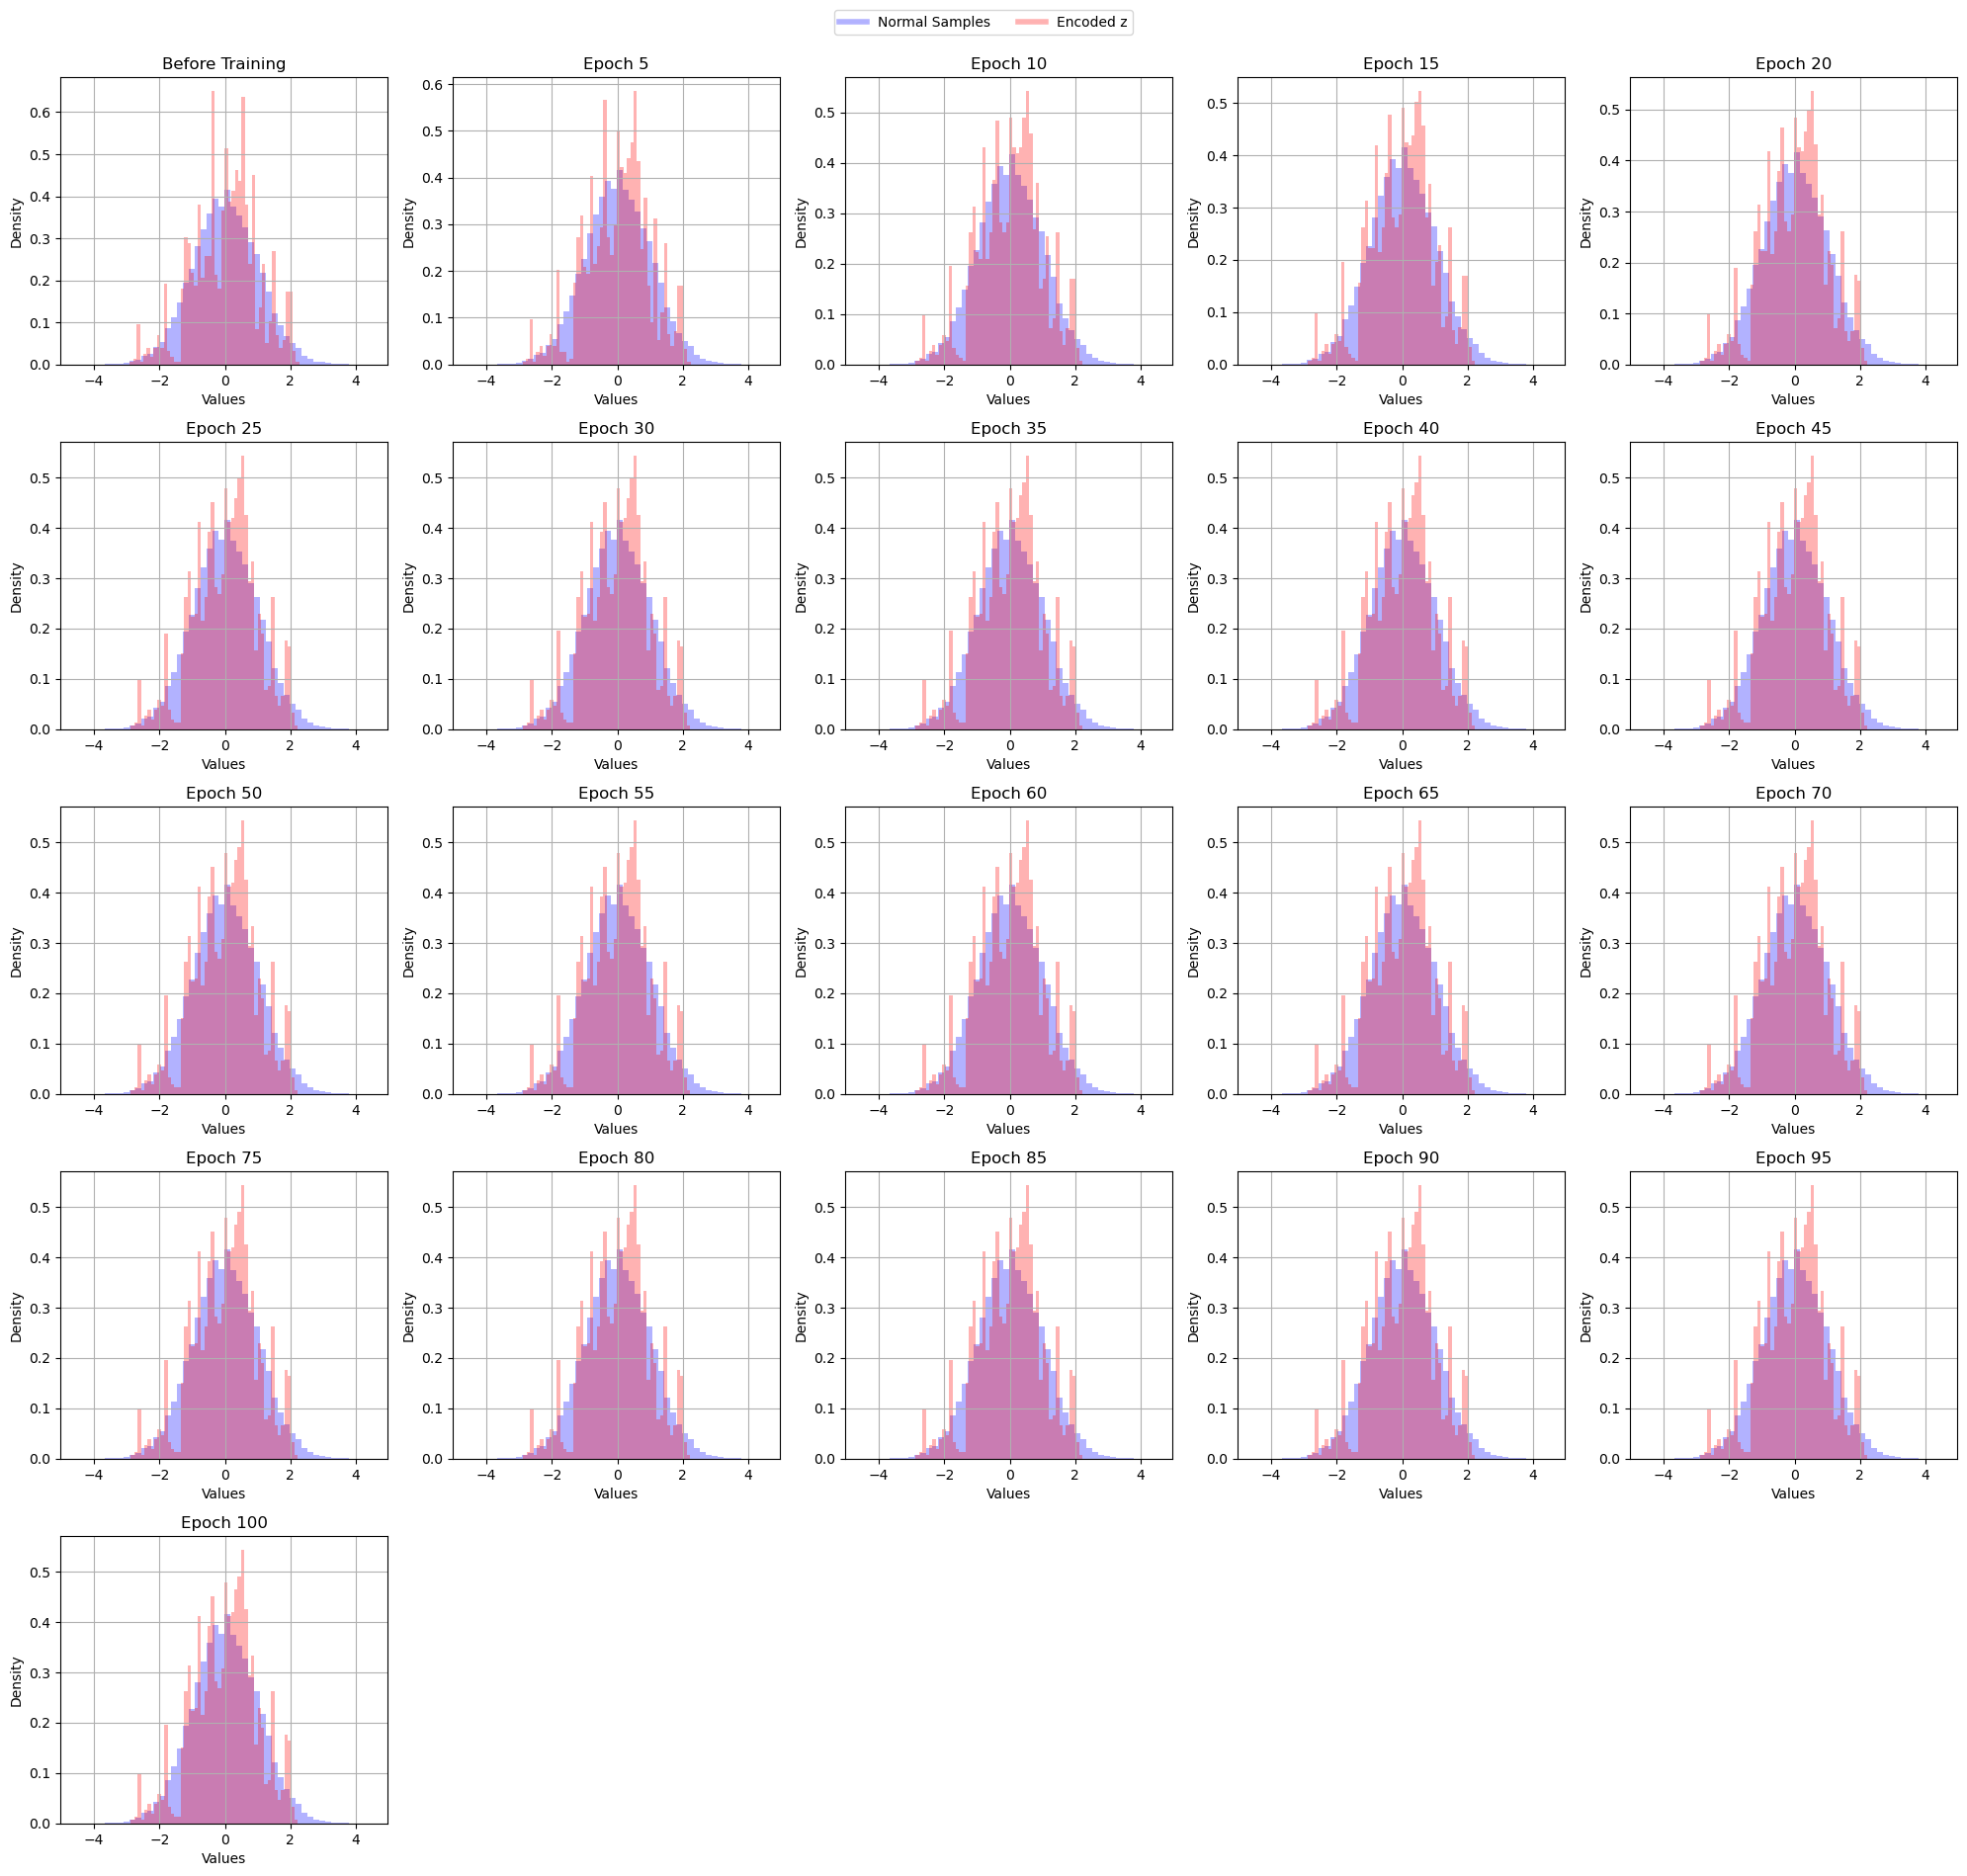

In [34]:
analyse_training(model_in=model2,
train_loss=train_loss2, val_loss=val_loss2, 
                test_data=test_data, figsize=(20,20),
                model_params_list=epoch_wise_param_list,
                num_coeffs=10,print_model_params=0, plot_freq=5) # 40 more (30 below+40 x3 below + 40  more= 70+40+40 + 40=110+40 +40=150+40=190)